## **Análise de dados - Covid19**

In [ ]:
"""
Módulo de configuração inicial para análise e visualização de dados COVID-19.

Inclui:
- Importação de bibliotecas padrão e de análise
- Configuração do ambiente para notebooks (Plotly inline)
"""

# Bibliotecas padrão
import os
import json
import zipfile
import glob

# Bibliotecas de análise e manipulação de dados
import pandas as pd
import numpy as np
from tqdm import tqdm
from scipy.signal import find_peaks

# Bibliotecas de visualização
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Configuração do ambiente Plotly para exibição inline (Colab)
import plotly.io as pio
pio.renderers.default = "colab"  # Exibe visualizações diretamente no notebook

## **ETL**

In [ ]:
"""
Pipeline de consolidação de dados COVID-19 Brasil.

Etapas:
1. Localiza o arquivo ZIP mais recente.
2. Extrai e lê todos os arquivos CSV contidos.
3. Realiza limpeza e padronização dos dados.
4. Salva o dataset unificado em formato CSV consolidado.
"""

import os
import zipfile
import glob
import pandas as pd
from tqdm import tqdm

# Caminhos de entrada e saída
data_dir = r"C:\Users\rafae.RAFAEL_NOTEBOOK\Downloads\covid19_SP\data"
extract_path = r"C:\Users\rafae.RAFAEL_NOTEBOOK\Downloads\covid19_SP\SaS_Cov19_project\output\COVIDBR"
output_csv = os.path.join(extract_path, "COVIDBR_2020_2025_Consolidado.csv")

# Localiza automaticamente o arquivo ZIP mais recente
zip_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(".zip")]
if not zip_files:
    raise FileNotFoundError("Nenhum arquivo ZIP encontrado no diretório especificado.")

zip_path = max(zip_files, key=os.path.getmtime)
print(f"Arquivo ZIP detectado: {os.path.basename(zip_path)}")

# Extração dos arquivos
print(f"Extraindo arquivos para {extract_path} ...")
os.makedirs(extract_path, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("Extração concluída.")

# Localiza todos os arquivos CSV extraídos
csv_files = glob.glob(os.path.join(extract_path, "HIST_PAINEL_COVIDBR_*.csv"))
print(f"{len(csv_files)} arquivos CSV encontrados:")
for f in csv_files:
    print(" -", os.path.basename(f))

# Lê e une todos os CSVs
dfs = []
for file in csv_files:
    print(f"Lendo {os.path.basename(file)} ...")
    df = pd.read_csv(file, sep=';', encoding='utf-8', low_memory=False)
    dfs.append(df)

df_final = pd.concat(dfs, ignore_index=True)
print(f"Dataset unificado: {df_final.shape[0]:,} linhas e {df_final.shape[1]} colunas.".replace(",", "."))

# Padronização e limpeza de dados
df_final['data'] = pd.to_datetime(df_final['data'], errors='coerce')
df_final.sort_values(by=['estado', 'municipio', 'data'], inplace=True)

df_final['estado'].fillna('BR', inplace=True)
df_final['municipio'].fillna('Não informado', inplace=True)
df_final['nomeRegiaoSaude'].fillna('Ignorado', inplace=True)
df_final['codRegiaoSaude'].fillna(-1, inplace=True)
df_final['interior/metropolitana'].fillna('Ignorado', inplace=True)

# Preenche população (mediana por estado)
df_final['populacaoTCU2019'] = (
    df_final.groupby('estado')['populacaoTCU2019']
    .transform(lambda x: x.fillna(x.median()))
)

# Substitui NaNs de casos e óbitos por zero
for col in ['casosAcumulado', 'casosNovos', 'obitosAcumulado', 'obitosNovos']:
    if col in df_final.columns:
        df_final[col] = df_final[col].fillna(0)

# Remove colunas irrelevantes
cols_to_drop = [c for c in ['Recuperadosnovos', 'emAcompanhamentoNovos', 'codmun'] if c in df_final.columns]
df_final.drop(columns=cols_to_drop, inplace=True, errors='ignore')

# Salvamento incremental em CSV
chunk_size = 100_000
num_chunks = (len(df_final) // chunk_size) + 1
print("Salvando dataset consolidado com tqdm...\n")
os.makedirs(os.path.dirname(output_csv), exist_ok=True)

with open(output_csv, "w", encoding="utf-8", newline="") as f:
    df_final.iloc[:0].to_csv(f, sep=';', index=False)
    for i in tqdm(range(num_chunks), desc="Salvando blocos", unit="chunk"):
        start = i * chunk_size
        end = min((i + 1) * chunk_size, len(df_final))
        df_final.iloc[start:end].to_csv(f, sep=';', index=False, header=False)

# Resumo final
size_mb = os.path.getsize(output_csv) / 1024 / 1024
print(f"\nArquivo consolidado salvo com sucesso em: {output_csv}")
print(f"Tamanho final: {size_mb:.2f} MB")
print(f"Total de linhas: {len(df_final):,}".replace(",", "."))
print(f"Intervalo de datas: {df_final['data'].min().date()} → {df_final['data'].max().date()}")

## **Análise dados COVID**

In [2]:
# Lê o dataset consolidado
df = pd.read_csv(
    r"C:\Users\rafae.RAFAEL_NOTEBOOK\Downloads\covid19_SP\SaS_Cov19_project\output\COVIDBR\COVIDBR_2020_2025_Consolidado.csv",
    sep=';',
    encoding='utf-8',
    low_memory=False
)

# Exibe as primeiras linhas
df.head()

regiao estado   municipio  coduf  codRegiaoSaude     nomeRegiaoSaude  \
0  Norte     AC  Acrelândia     12         12002.0  BAIXO ACRE E PURUS   
1  Norte     AC  Acrelândia     12         12002.0  BAIXO ACRE E PURUS   
2  Norte     AC  Acrelândia     12         12002.0  BAIXO ACRE E PURUS   
3  Norte     AC  Acrelândia     12         12002.0  BAIXO ACRE E PURUS   
4  Norte     AC  Acrelândia     12         12002.0  BAIXO ACRE E PURUS   

         data  semanaEpi  populacaoTCU2019  casosAcumulado  casosNovos  \
0  2020-03-27         13           15256.0             0.0           0   
1  2020-03-28         13           15256.0             0.0           0   
2  2020-03-29         14           15256.0             2.0           2   
3  2020-03-30         14           15256.0             6.0           4   
4  2020-03-31         14           15256.0             7.0           1   

   obitosAcumulado  obitosNovos interior/metropolitana  
0                0            0                    0.0  
1                0            0                    0.0  
2                0            0                    0.0  
3                0            0                    0.0  
4                0            0                    0.0

In [3]:
# Converte a coluna de data
df['data'] = pd.to_datetime(df['data'], errors='coerce')

In [4]:
# Exibe estatísticas gerais
print("Período:", df['data'].min(), "→", df['data'].max())
print("Estados:", df['estado'].nunique())
print("Municípios:", df['municipio'].nunique())
print("Total de registros:", len(df))

Período: 2020-02-25 00:00:00 → 2025-09-05 00:00:00
Estados: 28
Municípios: 5298
Total de registros: 11177059


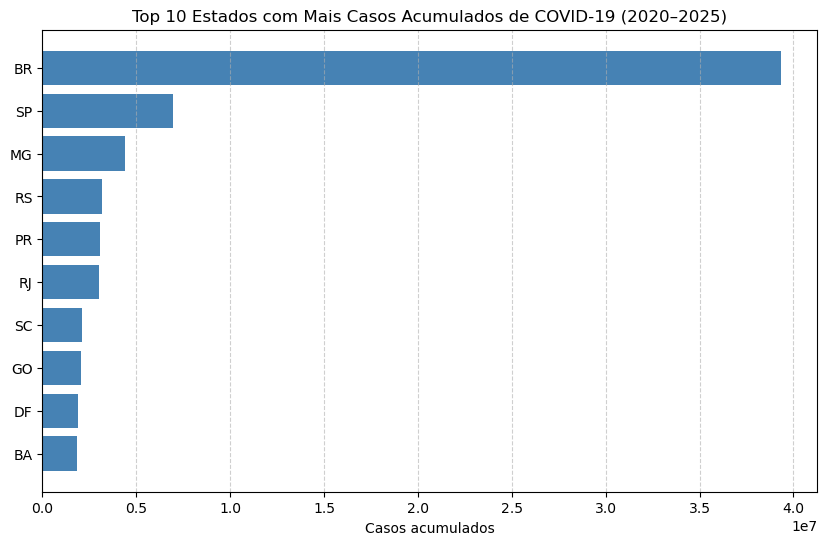

In [5]:
# Agrega dados por estado
df_estado = df.groupby('estado', as_index=False).agg({
    'casosAcumulado': 'max',
    'obitosAcumulado': 'max',
    'populacaoTCU2019': 'max'
})

# Calcula taxas e indicadores epidemiológicos
df_estado['taxa_incidencia'] = (df_estado['casosAcumulado'] / df_estado['populacaoTCU2019']) * 100000
df_estado['taxa_mortalidade'] = (df_estado['obitosAcumulado'] / df_estado['populacaoTCU2019']) * 100000
df_estado['letalidade_%'] = (df_estado['obitosAcumulado'] / df_estado['casosAcumulado']) * 100

# Seleciona os 10 estados com mais casos acumulados
top10 = df_estado.sort_values('casosAcumulado', ascending=False).head(10)

# Cria gráfico de barras horizontais
plt.figure(figsize=(10, 6))
plt.barh(top10['estado'], top10['casosAcumulado'], color='steelblue')
plt.title('Top 10 Estados com Mais Casos Acumulados de COVID-19 (2020–2025)')
plt.xlabel('Casos acumulados')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

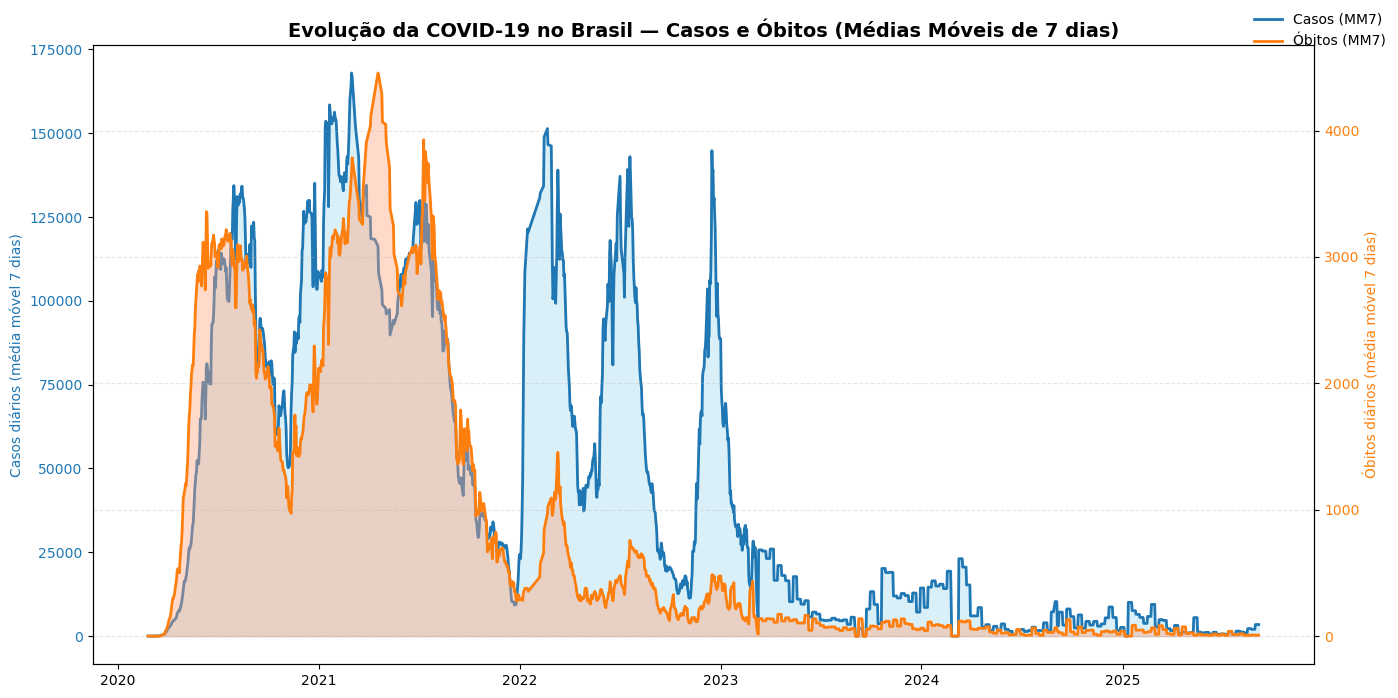

In [6]:
# Agrega dados nacionais por data
df_brasil = df.groupby('data')[['casosNovos', 'obitosNovos']].sum().reset_index()
df_brasil['data'] = pd.to_datetime(df_brasil['data'])

# Substitui valores nulos por zero
df_brasil.fillna(0, inplace=True)

# Remove valores negativos ou extremos
df_brasil = df_brasil[
    (df_brasil['casosNovos'] >= 0) & (df_brasil['casosNovos'] < 200000) &
    (df_brasil['obitosNovos'] >= 0) & (df_brasil['obitosNovos'] < 5000)
]

# Calcula médias móveis de 7 dias
df_brasil['casosMM7'] = df_brasil['casosNovos'].rolling(7, min_periods=1).mean()
df_brasil['obitosMM7'] = df_brasil['obitosNovos'].rolling(7, min_periods=1).mean()

# Cria gráfico com dois eixos Y
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plota casos (eixo esquerdo)
ax1.plot(df_brasil['data'], df_brasil['casosMM7'], color='tab:blue', linewidth=2, label='Casos (MM7)')
ax1.fill_between(df_brasil['data'], df_brasil['casosMM7'], color='skyblue', alpha=0.3)
ax1.set_ylabel('Casos diários (média móvel 7 dias)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.xaxis.set_major_locator(mdates.YearLocator())

# Plota óbitos (eixo direito)
ax2 = ax1.twinx()
ax2.plot(df_brasil['data'], df_brasil['obitosMM7'], color='tab:orange', linewidth=2, label='Óbitos (MM7)')
ax2.fill_between(df_brasil['data'], df_brasil['obitosMM7'], color='lightsalmon', alpha=0.4)
ax2.set_ylabel('Óbitos diários (média móvel 7 dias)', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Define título e legenda
plt.title('Evolução da COVID-19 no Brasil — Casos e Óbitos (Médias Móveis de 7 dias)', fontsize=14, weight='bold')
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
fig.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=10, frameon=False)
plt.grid(alpha=0.3, linestyle='--')
fig.tight_layout()
plt.show()

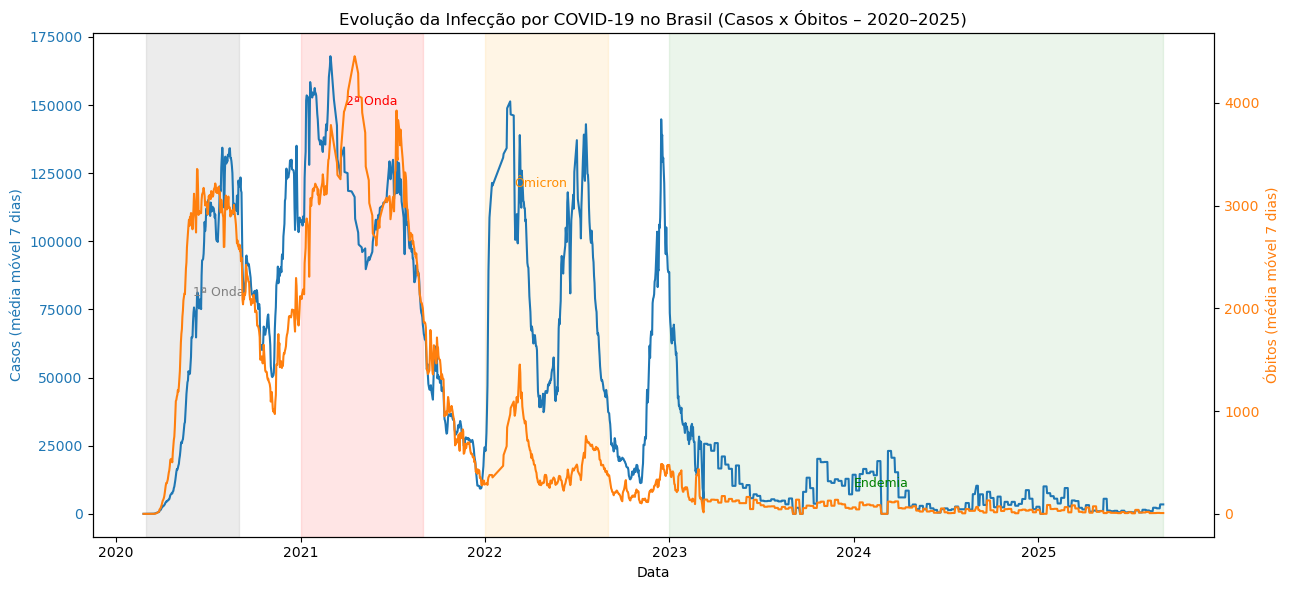

In [8]:
# Cria gráfico com dois eixos Y
fig, ax1 = plt.subplots(figsize=(13, 6))

# Plota a linha azul representando os casos (média móvel de 7 dias)
ax1.plot(df_brasil['data'], df_brasil['casosMM7'],
         color='tab:blue', label='Casos novos (MM7)')
ax1.set_xlabel('Data')
ax1.set_ylabel('Casos (média móvel 7 dias)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Adiciona o segundo eixo (à direita) para representar óbitos
ax2 = ax1.twinx()
ax2.plot(df_brasil['data'], df_brasil['obitosMM7'],
         color='tab:orange', label='Óbitos novos (MM7)')
ax2.set_ylabel('Óbitos (média móvel 7 dias)', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Adiciona áreas coloridas para destacar fases da pandemia
ax1.axvspan('2020-03-01', '2020-09-01', color='gray', alpha=0.15)
ax1.axvspan('2021-01-01', '2021-09-01', color='red', alpha=0.10)
ax1.axvspan('2022-01-01', '2022-09-01', color='orange', alpha=0.10)
ax1.axvspan('2023-01-01', '2025-09-05', color='green', alpha=0.08)

# Adiciona anotações para indicar as ondas e fases da pandemia
ax1.text(pd.Timestamp('2020-06-01'), 80000, "1ª Onda", fontsize=9, color='gray')
ax1.text(pd.Timestamp('2021-04-01'), 150000, "2ª Onda", fontsize=9, color='red')
ax1.text(pd.Timestamp('2022-03-01'), 120000, "Ômicron", fontsize=9, color='darkorange')
ax1.text(pd.Timestamp('2024-01-01'), 10000, "Endemia", fontsize=9, color='green')

# Define título, ajusta layout e exibe o gráfico
plt.title("Evolução da Infecção por COVID-19 no Brasil (Casos x Óbitos – 2020–2025)")
fig.tight_layout()
plt.grid(False)
plt.show()


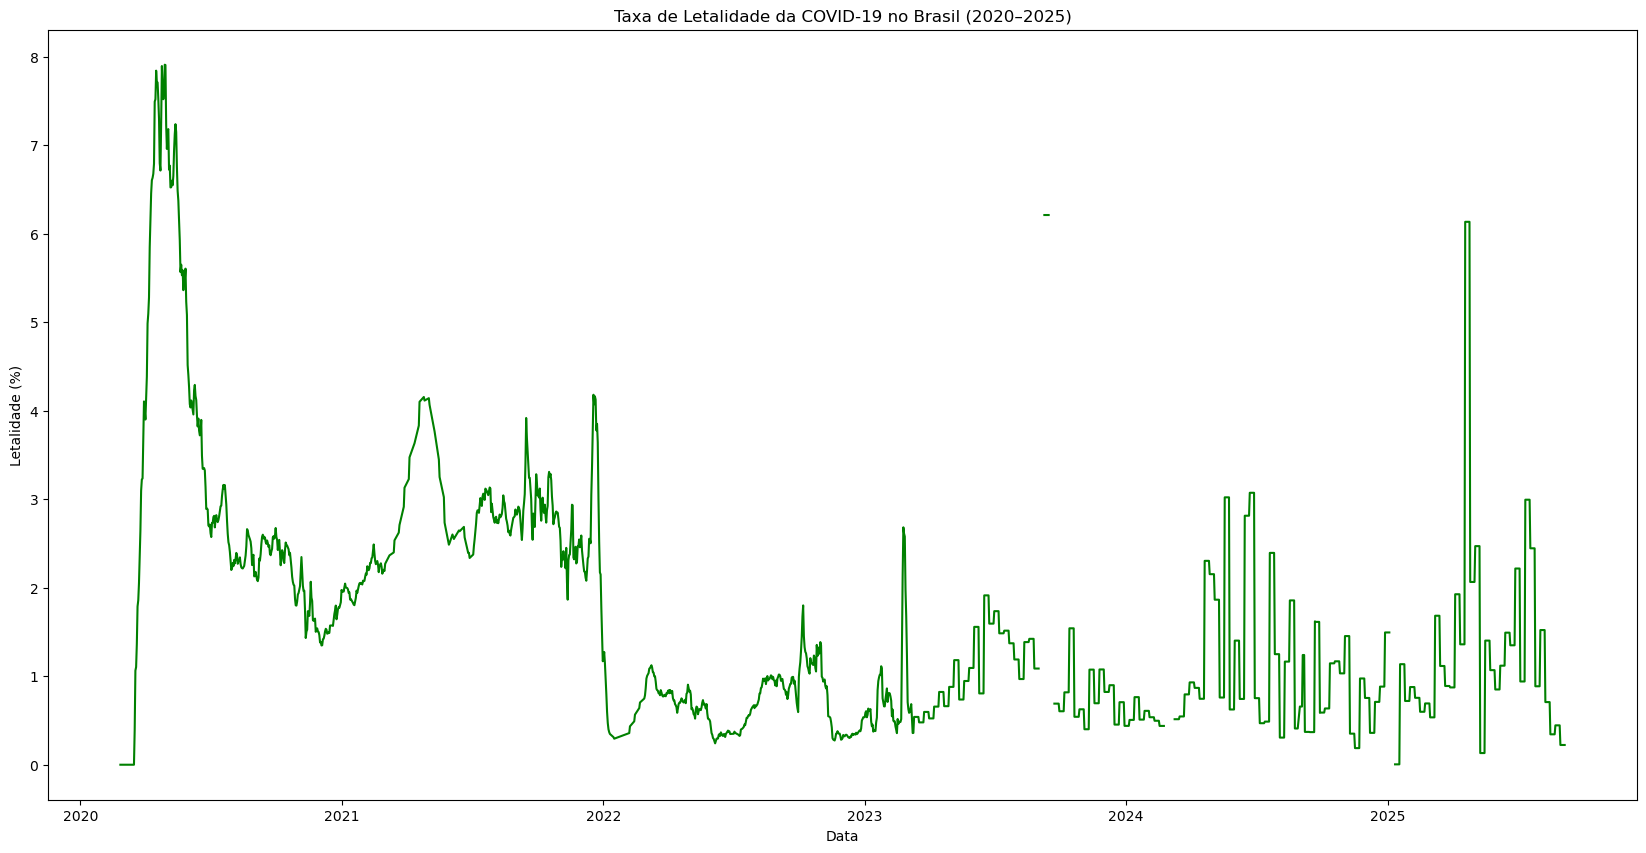

In [9]:
# Taxa de letalidade diária (óbitos / casos)
df_brasil['letalidade_%'] = (df_brasil['obitosMM7'] / df_brasil['casosMM7']) * 100

plt.figure(figsize=(20.5, 10))
plt.plot(df_brasil['data'], df_brasil['letalidade_%'], color='green')
plt.title('Taxa de Letalidade da COVID-19 no Brasil (2020–2025)')
plt.xlabel('Data')
plt.ylabel('Letalidade (%)')
plt.grid(False)
plt.show()

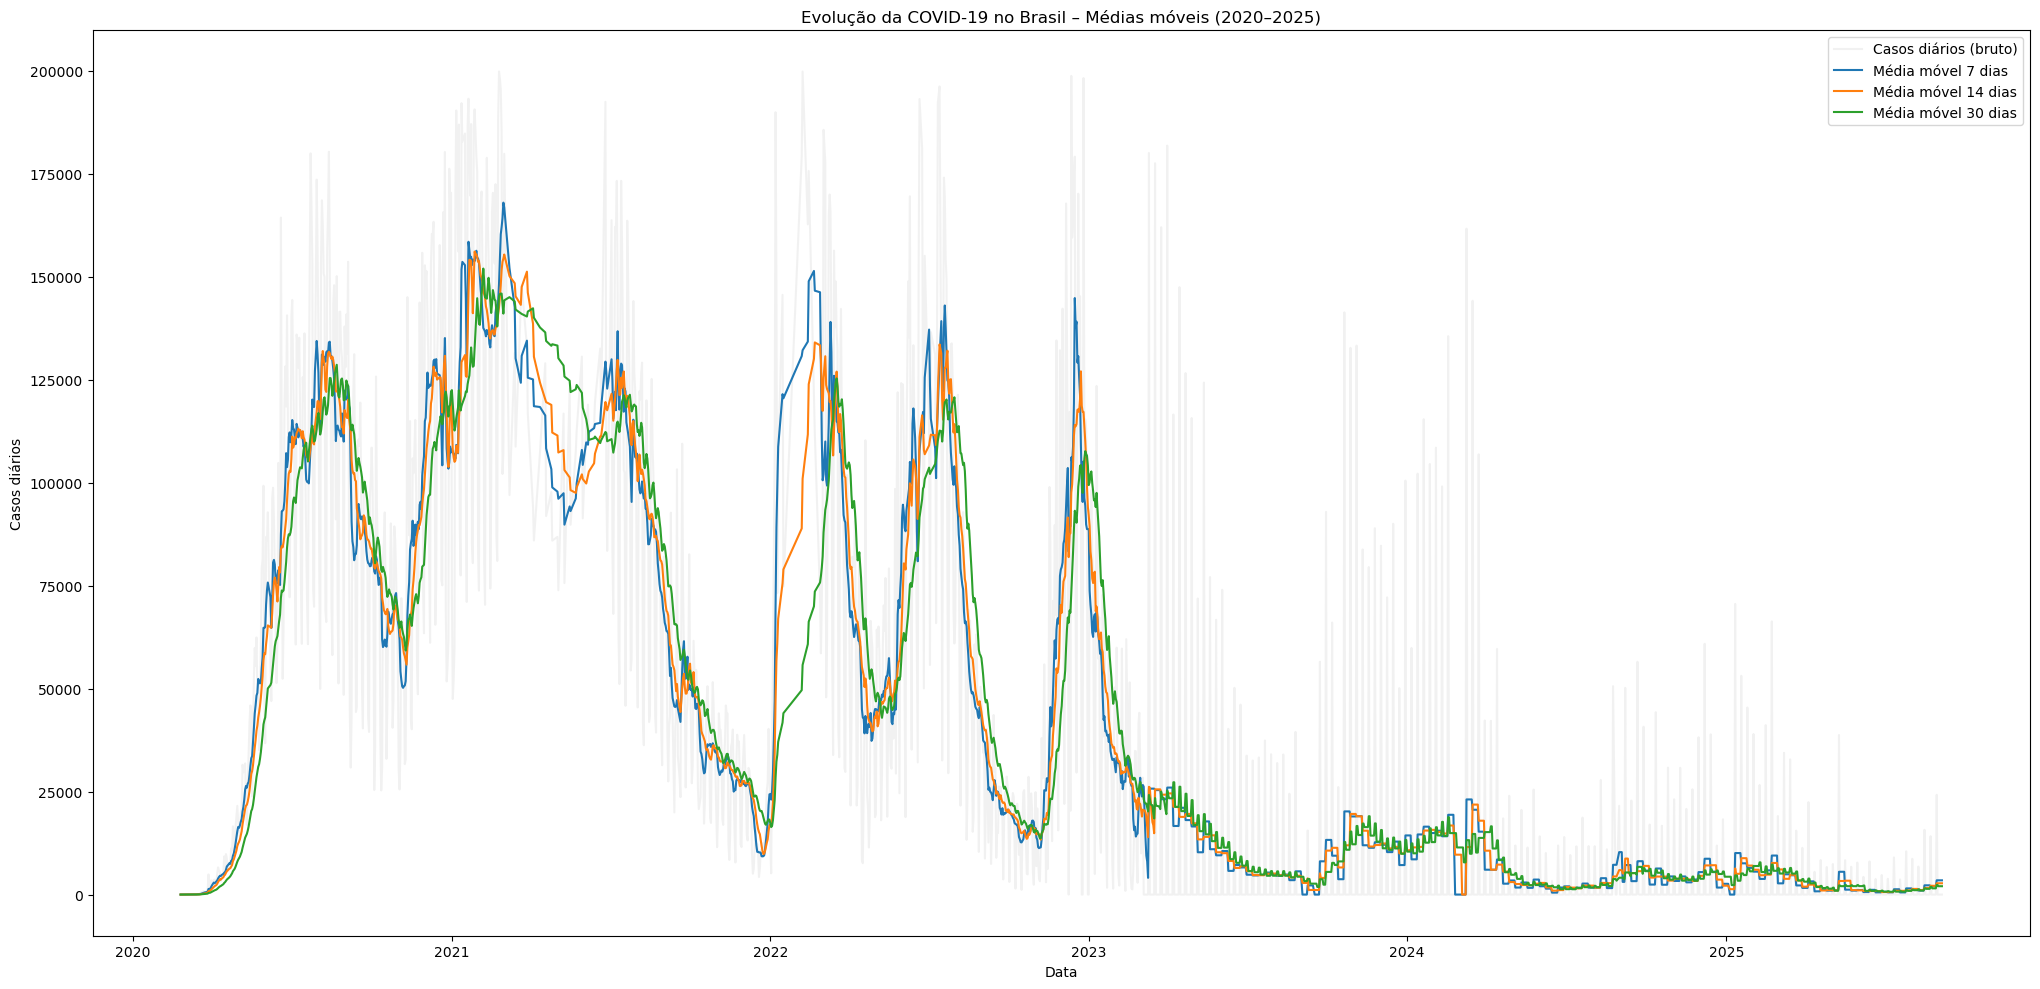

In [10]:
# Calcular médias móveis
df_brasil['MM7']  = df_brasil['casosNovos'].rolling(window=7,  min_periods=1).mean()
df_brasil['MM14'] = df_brasil['casosNovos'].rolling(window=14, min_periods=1).mean()
df_brasil['MM30'] = df_brasil['casosNovos'].rolling(window=30, min_periods=1).mean()

# Plotar
plt.figure(figsize=(20.5, 10))
plt.plot(df_brasil['data'], df_brasil['casosNovos'], color='lightgray', alpha=0.3, label='Casos diários (bruto)')
plt.plot(df_brasil['data'], df_brasil['MM7'],  color='tab:blue', label='Média móvel 7 dias')
plt.plot(df_brasil['data'], df_brasil['MM14'], color='tab:orange', label='Média móvel 14 dias')
plt.plot(df_brasil['data'], df_brasil['MM30'], color='tab:green', label='Média móvel 30 dias')

plt.title("Evolução da COVID-19 no Brasil – Médias móveis (2020–2025)")
plt.xlabel("Data")
plt.ylabel("Casos diários")
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

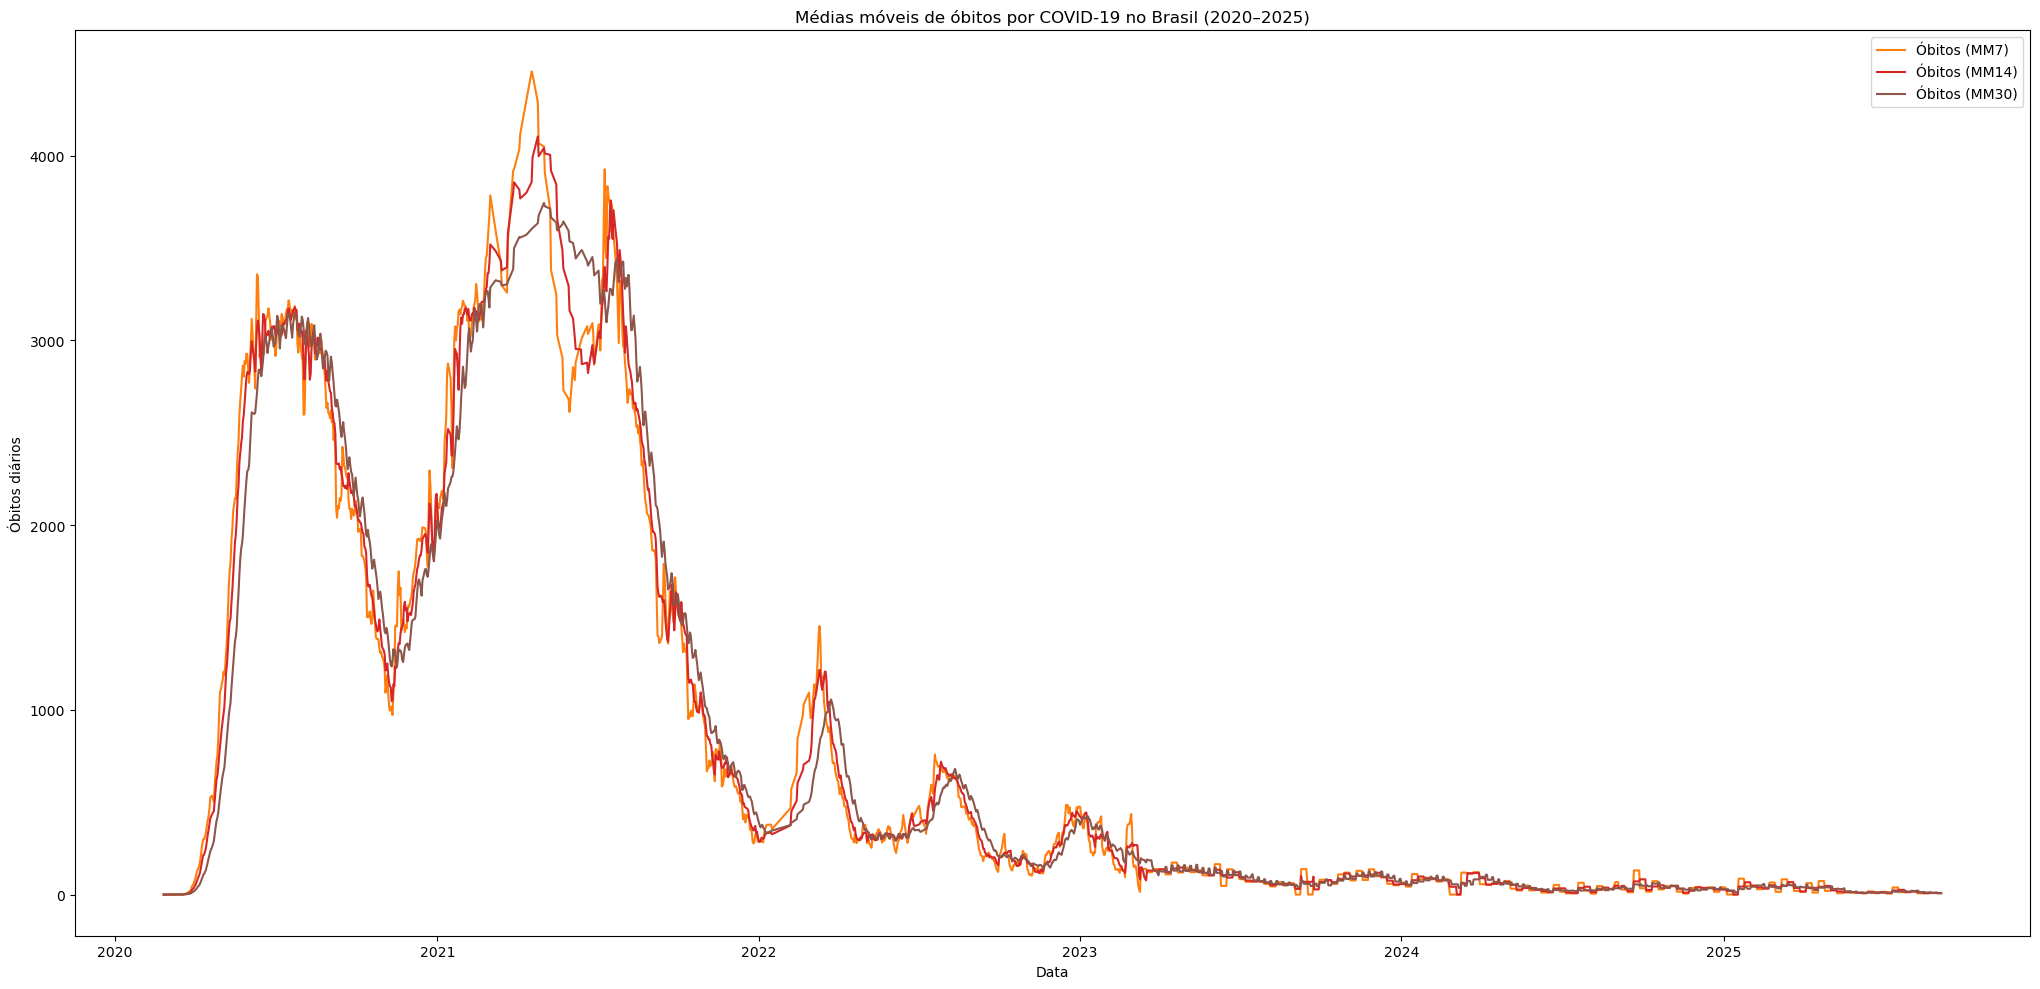

In [11]:
# Médias móveis de óbitos
df_brasil['obitosMM7']  = df_brasil['obitosNovos'].rolling(7,  min_periods=1).mean()
df_brasil['obitosMM14'] = df_brasil['obitosNovos'].rolling(14, min_periods=1).mean()
df_brasil['obitosMM30'] = df_brasil['obitosNovos'].rolling(30, min_periods=1).mean()

# Gráfico conjunto
plt.figure(figsize=(20.5, 10))
plt.plot(df_brasil['data'], df_brasil['obitosMM7'],  color='tab:orange', label='Óbitos (MM7)')
plt.plot(df_brasil['data'], df_brasil['obitosMM14'], color='tab:red', label='Óbitos (MM14)')
plt.plot(df_brasil['data'], df_brasil['obitosMM30'], color='tab:brown', label='Óbitos (MM30)')
plt.title("Médias móveis de óbitos por COVID-19 no Brasil (2020–2025)")
plt.xlabel("Data")
plt.ylabel("Óbitos diários")
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

In [12]:
# Prepara a base de dados agregada por estado (UF)
df_estados = (
    df.groupby('estado')[['casosAcumulado', 'obitosAcumulado', 'populacaoTCU2019']]
    .max()
    .reset_index()
)

# Calcula indicadores epidemiológicos por 100 mil habitantes
df_estados['taxa_incidencia'] = (
    df_estados['casosAcumulado'] / df_estados['populacaoTCU2019']
) * 100000
df_estados['taxa_mortalidade'] = (
    df_estados['obitosAcumulado'] / df_estados['populacaoTCU2019']
) * 100000

# Agrega novamente os dados por estado para garantir consistência
df_estados = (
    df.groupby('estado')[['casosAcumulado', 'obitosAcumulado', 'populacaoTCU2019']]
    .max()
    .reset_index()
)

# Substitui siglas por nomes completos dos estados brasileiros
df_estados['estado'] = df_estados['estado'].replace({
    'DF': 'Distrito Federal',
    'SP': 'São Paulo',
    'RJ': 'Rio de Janeiro',
    'MG': 'Minas Gerais',
    'BA': 'Bahia',
    'RS': 'Rio Grande do Sul',
    'PR': 'Paraná',
    'SC': 'Santa Catarina',
    'GO': 'Goiás',
    'PE': 'Pernambuco',
    'CE': 'Ceará',
    'PA': 'Pará',
    'AM': 'Amazonas',
    'MA': 'Maranhão',
    'ES': 'Espírito Santo',
    'MT': 'Mato Grosso',
    'PB': 'Paraíba',
    'RN': 'Rio Grande do Norte',
    'MS': 'Mato Grosso do Sul',
    'PI': 'Piauí',
    'AL': 'Alagoas',
    'SE': 'Sergipe',
    'RO': 'Rondônia',
    'TO': 'Tocantins',
    'AC': 'Acre',
    'AP': 'Amapá',
    'RR': 'Roraima'
})

# Recalcula taxas de incidência e mortalidade por 100 mil habitantes
df_estados['taxa_incidencia'] = (
    df_estados['casosAcumulado'] / df_estados['populacaoTCU2019']
) * 100000
df_estados['taxa_mortalidade'] = (
    df_estados['obitosAcumulado'] / df_estados['populacaoTCU2019']
) * 100000

# Carrega o arquivo GeoJSON oficial com os limites geográficos dos estados do Brasil
url_geo = (
    'https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson'
)
geojson_brasil = requests.get(url_geo).json()

# Cria um mapa coroplético interativo da taxa de incidência por estado
fig_casos = px.choropleth(
    df_estados,
    geojson=geojson_brasil,
    featureidkey='properties.name',  # chave de ligação com o GeoJSON
    locations='estado',
    color='taxa_incidencia',
    color_continuous_scale='YlOrRd',
    title='Taxa de Incidência de COVID-19 por Estado (por 100 mil habitantes)',
    hover_data=['casosAcumulado', 'populacaoTCU2019']
)

# Ajusta o enquadramento do mapa e o layout do título
fig_casos.update_geos(fitbounds="locations", visible=False)
fig_casos.update_layout(title_x=0.5, title_font=dict(size=18))

# Exibe o mapa interativo
fig_casos.show()


In [14]:
fig_obitos = px.choropleth(
    df_estados,
    geojson=geojson_brasil,
    featureidkey='properties.name',
    locations='estado',
    color='taxa_mortalidade',
    color_continuous_scale='Reds',
    title='Taxa de Mortalidade por COVID-19 por Estado (por 100 mil habitantes)',
    hover_data=['obitosAcumulado', 'populacaoTCU2019']
)

fig_obitos.update_geos(fitbounds="locations", visible=False)
fig_obitos.update_layout(title_x=0.5, title_font=dict(size=18))
fig_obitos.show()


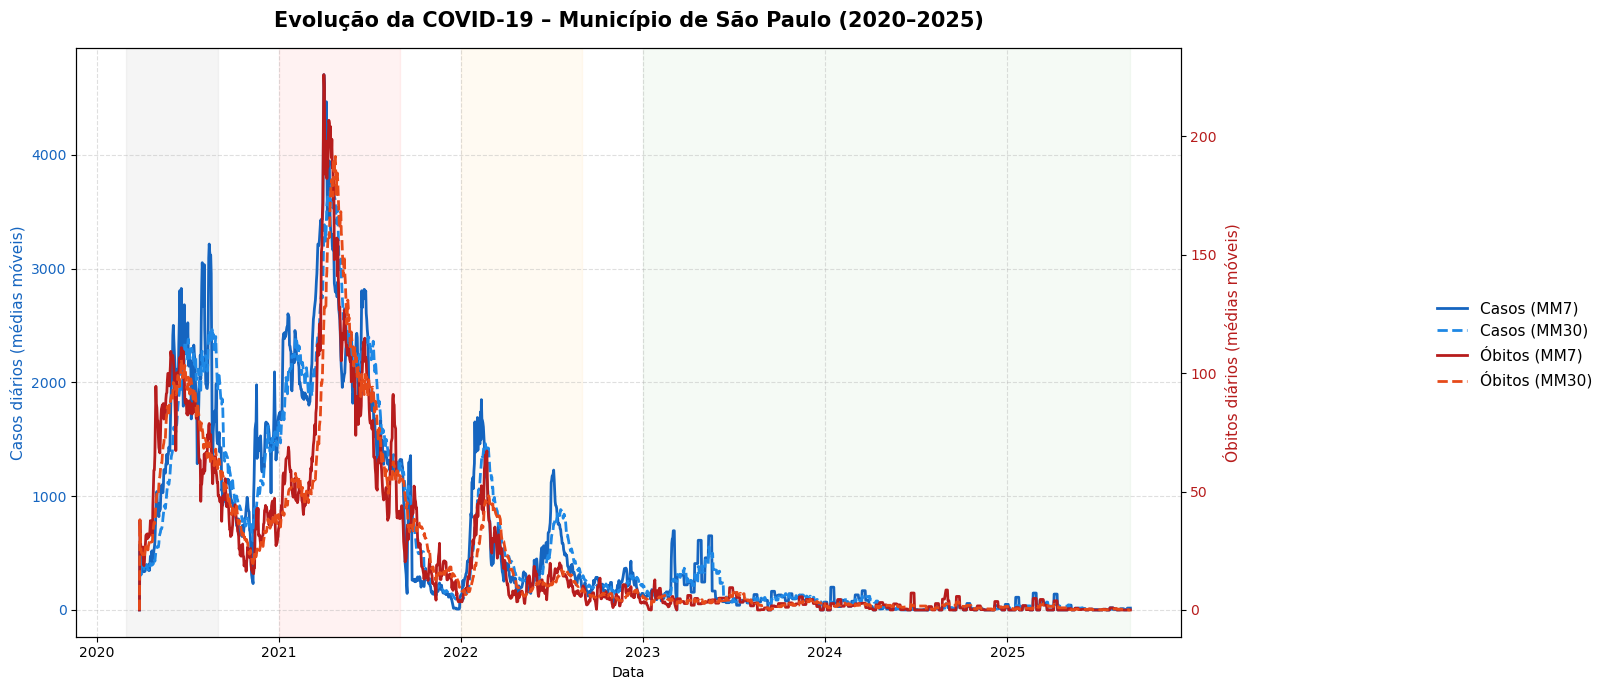

In [17]:
# Filtra apenas os registros do município de São Paulo (capital)
df_sp = df[df["municipio"] == "São Paulo"].copy()
df_sp = df_sp.sort_values("data")

# Remove linhas com valores nulos, negativos ou fora da faixa considerada plausível
df_sp = df_sp[
    (df_sp["casosNovos"].notna())
    & (df_sp["obitosNovos"].notna())
    & (df_sp["casosNovos"] >= 0)
    & (df_sp["obitosNovos"] >= 0)
    & (df_sp["casosNovos"] < 10000)  # limita valores diários para evitar outliers municipais
    & (df_sp["obitosNovos"] < 500)
]

# Calcula médias móveis de 7 e 30 dias para casos e óbitos
df_sp["casosMM7"] = df_sp["casosNovos"].rolling(window=7, min_periods=1).mean()
df_sp["casosMM30"] = df_sp["casosNovos"].rolling(window=30, min_periods=1).mean()
df_sp["obitosMM7"] = df_sp["obitosNovos"].rolling(window=7, min_periods=1).mean()
df_sp["obitosMM30"] = df_sp["obitosNovos"].rolling(window=30, min_periods=1).mean()

# Cria o gráfico com dois eixos Y (casos e óbitos)
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plota as curvas de casos (eixo esquerdo)
ax1.plot(df_sp["data"], df_sp["casosMM7"], color="#1565C0", linewidth=2, label="Casos (MM7)")
ax1.plot(df_sp["data"], df_sp["casosMM30"], color="#1E88E5", linestyle="--", linewidth=2, label="Casos (MM30)")
ax1.set_ylabel("Casos diários (médias móveis)", color="#1565C0", fontsize=11)
ax1.tick_params(axis="y", labelcolor="#1565C0")

# Plota as curvas de óbitos (eixo direito)
ax2 = ax1.twinx()
ax2.plot(df_sp["data"], df_sp["obitosMM7"], color="#B71C1C", linewidth=2, label="Óbitos (MM7)")
ax2.plot(df_sp["data"], df_sp["obitosMM30"], color="#E64A19", linestyle="--", linewidth=2, label="Óbitos (MM30)")
ax2.set_ylabel("Óbitos diários (médias móveis)", color="#B71C1C", fontsize=11)
ax2.tick_params(axis="y", labelcolor="#B71C1C")

# Adiciona faixas verticais para representar períodos de ondas epidêmicas
ax1.axvspan("2020-03-01", "2020-09-01", color="gray", alpha=0.08)
ax1.axvspan("2021-01-01", "2021-09-01", color="red", alpha=0.05)
ax1.axvspan("2022-01-01", "2022-09-01", color="orange", alpha=0.05)
ax1.axvspan("2023-01-01", "2025-09-05", color="green", alpha=0.04)

# Define título, eixos e grade do gráfico
plt.title("Evolução da COVID-19 – Município de São Paulo (2020–2025)",
          fontsize=15, weight="bold", pad=15)
ax1.set_xlabel("Data")
ax1.grid(True, linestyle="--", alpha=0.4)

# Formata o eixo X para exibir apenas o ano
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax1.xaxis.set_major_locator(mdates.YearLocator())

# Combina as legendas de ambos os eixos e posiciona fora do gráfico
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
fig.legend(
    lines1 + lines2,
    labels1 + labels2,
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=False,
    fontsize=11
)

# Ajusta o layout para evitar sobreposição de elementos
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()


In [23]:
# Calcula a matriz de correlação para colunas numéricas.
corr = df_brasil.corr(numeric_only=True)

# Seleciona apenas as correlações positivas e remove a diagonal.
corr_pos = corr.mask((corr <= 0) | (corr == 1))
corr_pairs = corr_pos.stack().reset_index()
corr_pairs.columns = ["Variável X", "Variável Y", "Correlação"]
corr_pairs = corr_pairs.sort_values("Correlação", ascending=False)

# Exibe as maiores correlações positivas.
print("Maiores correlações positivas:")
print(corr_pairs.head(5))

Maiores correlações positivas:
    Variável X  Variável Y  Correlação
33   obitosMM7  obitosMM14    0.996154
73  obitosMM14   obitosMM7    0.996154
87  obitosMM30  obitosMM14    0.991561
78  obitosMM14  obitosMM30    0.991561
57        MM14         MM7    0.990812


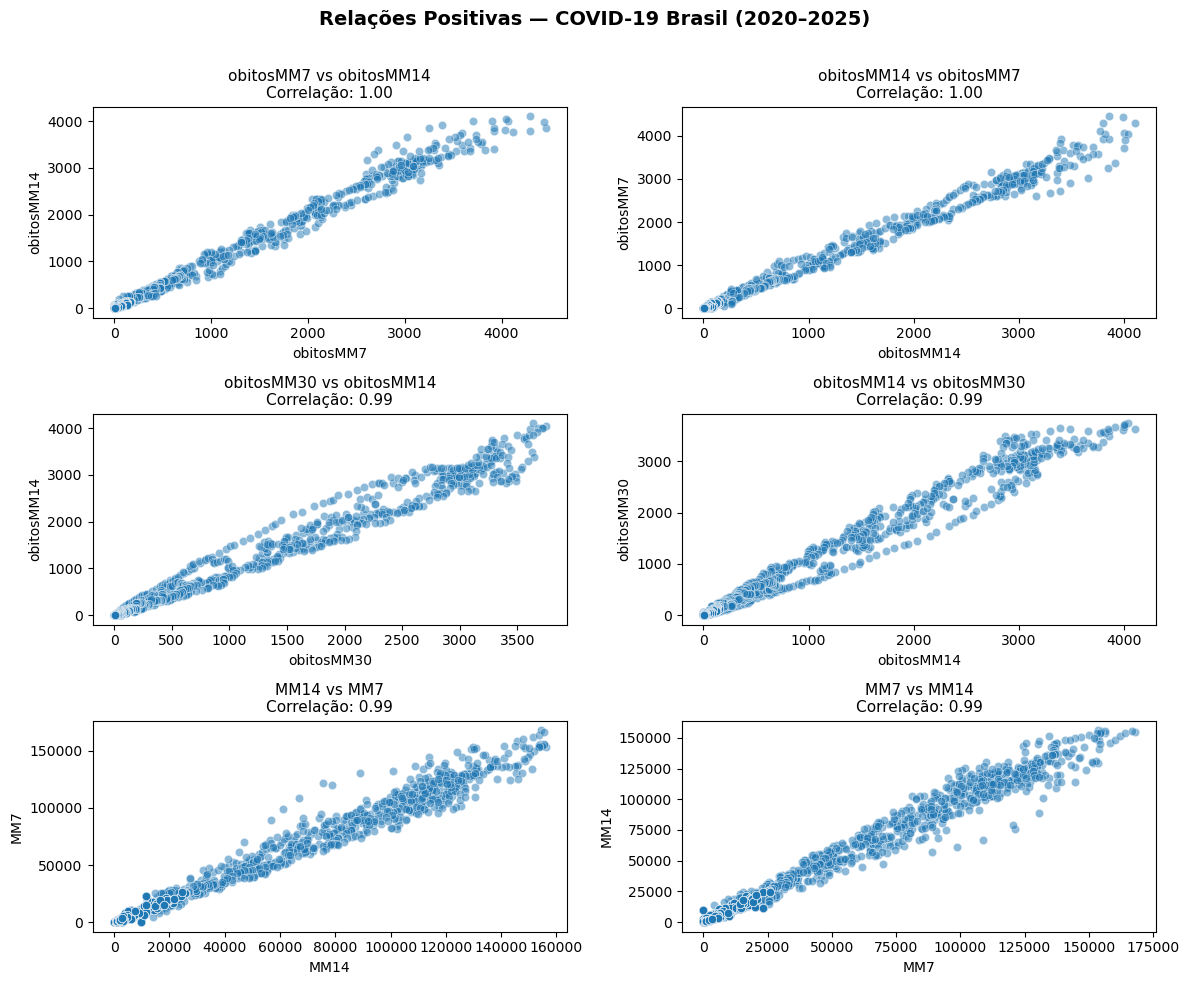

In [24]:
# Gera gráficos de dispersão para as principais correlações positivas.
plt.figure(figsize=(12, 10))
for i, (x, y, r) in enumerate(corr_pairs.head(6).values, 1):
    plt.subplot(3, 2, i)
    sns.scatterplot(data=df_brasil, x=x, y=y, alpha=0.5, color="tab:blue")
    plt.title(f"{x} vs {y}\nCorrelação: {r:.2f}", fontsize=11)
    plt.xlabel(x)
    plt.ylabel(y)

# Ajusta o layout e adiciona o título geral da figura.
plt.suptitle(
    "Relações Positivas — COVID-19 Brasil (2020–2025)",
    fontsize=14,
    weight="bold"
)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

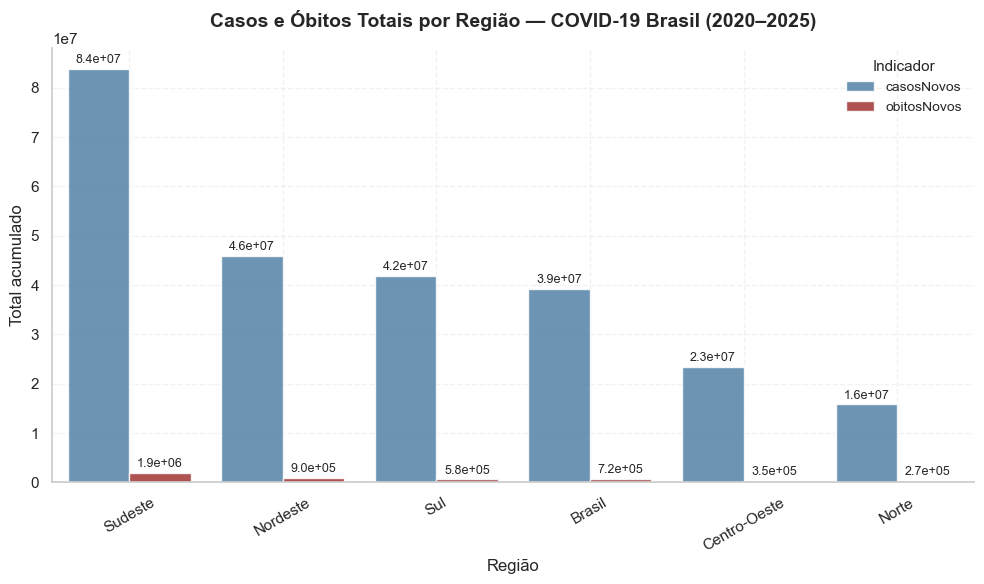

In [34]:
# define o caminho do dataset consolidado
csv_path = (
    r"C:\Users\rafae.RAFAEL_NOTEBOOK\Downloads\covid19_SP"
    r"\SaS_Cov19_project\output\COVIDBR\COVIDBR_2020_2025_Consolidado.csv"
)

# verifica se o arquivo existe
if not os.path.exists(csv_path):
    raise FileNotFoundError(f"O arquivo CSV não foi encontrado em: {csv_path}")

# carrega o dataset consolidado
df_final = pd.read_csv(csv_path, sep=';', encoding='utf-8', low_memory=False)

# cria uma cópia do dataframe e remove registros inválidos
df_inf = df_final.copy()
df_inf = df_inf[
    (df_inf["casosNovos"] >= 0)
    & (df_inf["obitosNovos"] >= 0)
    & (df_inf["casosNovos"].notna())
    & (df_inf["obitosNovos"].notna())
]

# cria a coluna "regiao" caso não exista
if "regiao" not in df_inf.columns:
    mapping = {
        "Norte": ["AC", "AM", "AP", "PA", "RO", "RR", "TO"],
        "Nordeste": ["AL", "BA", "CE", "MA", "PB", "PE", "PI", "RN", "SE"],
        "Centro-Oeste": ["DF", "GO", "MT", "MS"],
        "Sudeste": ["ES", "MG", "RJ", "SP"],
        "Sul": ["PR", "RS", "SC"],
    }

    # função auxiliar para mapear UF → região
    def get_region(uf):
        for region, states in mapping.items():
            if uf in states:
                return region
        return "Desconhecida"

    # aplica o mapeamento ao dataframe
    df_inf["regiao"] = df_inf["estado"].apply(get_region)

# agrupa os dados por região, somando casos e óbitos novos
df_region = (
    df_inf.groupby("regiao")[["casosNovos", "obitosNovos"]]
    .sum()
    .sort_values("casosNovos", ascending=False)
    .reset_index()
)

# define o estilo visual padrão
sns.set(style="whitegrid")

# cria a figura e o eixo principal
fig, ax = plt.subplots(figsize=(10, 6))

# converte o dataframe para formato longo (necessário para seaborn)
df_melt = df_region.melt(id_vars="regiao", var_name="Tipo", value_name="Total")

# plota o gráfico de barras agrupadas
sns.barplot(
    data=df_melt,
    x="regiao",
    y="Total",
    hue="Tipo",
    palette={"casosNovos": "steelblue", "obitosNovos": "firebrick"},
    alpha=0.85,
    ax=ax,
)

# configura o título, eixos e rotação dos rótulos
ax.set_title(
    "Casos e Óbitos Totais por Região — COVID-19 Brasil (2020–2025)",
    fontsize=14,
    weight="bold",
    pad=15,
)
ax.set_xlabel("Região", fontsize=12)
ax.set_ylabel("Total acumulado", fontsize=12)
ax.tick_params(axis="x", rotation=30)

# configura a legenda
ax.legend(
    title="Indicador",
    title_fontsize=11,
    fontsize=10,
    loc="upper right",
    frameon=False,
)

# adiciona rótulos com valores acima das barras
for container in ax.containers:
    ax.bar_label(container, fmt="%.1e", label_type="edge", fontsize=9, padding=2)

# remove bordas e adiciona uma grade leve
sns.despine()
plt.grid(alpha=0.25, linestyle="--")

# ajusta o layout e exibe o gráfico
plt.tight_layout()
plt.show()

C:\Users\rafae.RAFAEL_NOTEBOOK\AppData\Local\Temp\ipykernel_21484\2912241160.py:5: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



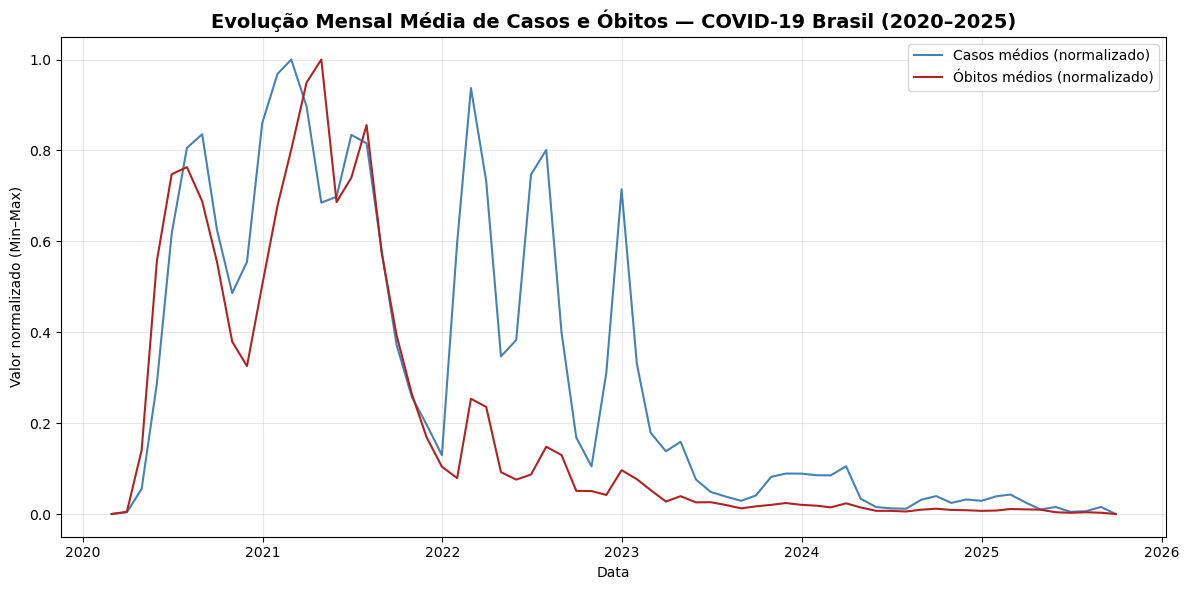

In [29]:
from sklearn.preprocessing import MinMaxScaler

# Cria um DataFrame com média mensal de casos e óbitos no Brasil
df_mes_mean = (
    df_brasil.groupby(pd.Grouper(key="data", freq="M"))[["casosNovos", "obitosNovos"]]
    .mean()
    .reset_index()
    .rename(columns={"casosNovos": "casos_mean", "obitosNovos": "obitos_mean"})
)

# Normaliza as séries para comparação no mesmo eixo
scaler = MinMaxScaler()
cols = ["casos_mean", "obitos_mean"]
df_norm = df_mes_mean.copy()
df_norm[cols] = scaler.fit_transform(df_mes_mean[cols])

# Cria o gráfico de evolução temporal (normalizado)
plt.figure(figsize=(12, 6))
plt.plot(df_norm["data"], df_norm["casos_mean"], label="Casos médios (normalizado)", color="steelblue")
plt.plot(df_norm["data"], df_norm["obitos_mean"], label="Óbitos médios (normalizado)", color="firebrick")

plt.title("Evolução Mensal Média de Casos e Óbitos — COVID-19 Brasil (2020–2025)", fontsize=14, weight="bold")
plt.xlabel("Data")
plt.ylabel("Valor normalizado (Min–Max)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


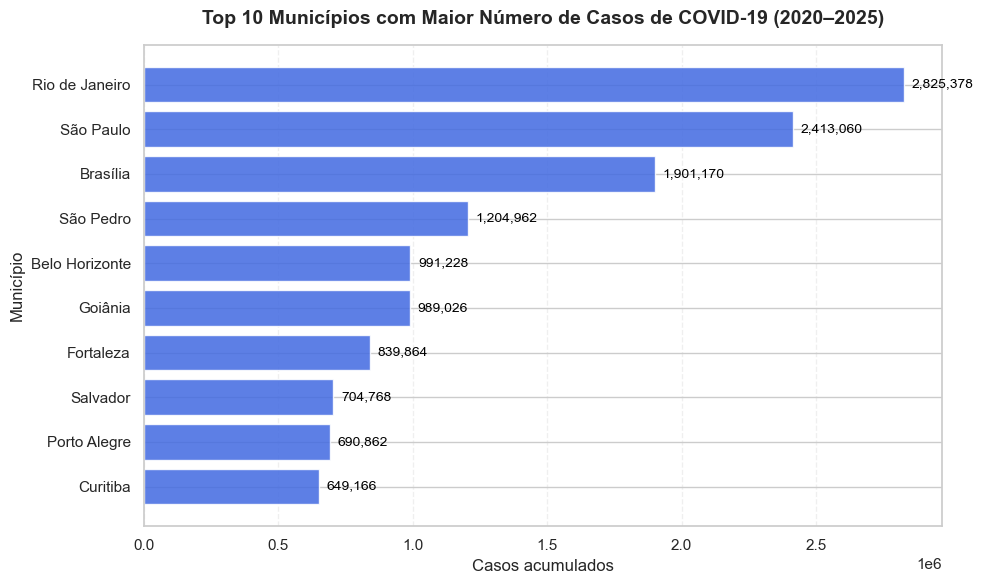

In [36]:
# agrupa os dados por município e seleciona o maior número de casos acumulados
top_cities = (
    df_inf.groupby("municipio")["casosAcumulado"]
    .max()
    .sort_values(ascending=False)
)

# remove a categoria "não informado" ou valores nulos
top_cities = top_cities[
    ~top_cities.index.str.contains("não informado", case=False, na=False)
]

# seleciona os 10 municípios com mais casos e ordena em ordem crescente
top_cities = top_cities.head(10).sort_values(ascending=True)

# cria a figura e define o estilo visual
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# plota gráfico de barras horizontais
bars = plt.barh(top_cities.index, top_cities.values, color="royalblue", alpha=0.85)

# adiciona rótulos com os valores ao final de cada barra
for bar in bars:
    width = bar.get_width()
    plt.text(
        width + 0.01 * top_cities.max(),
        bar.get_y() + bar.get_height() / 2,
        f"{width:,.0f}",
        va="center",
        fontsize=10,
        color="black",
    )

# configura título, rótulos e estilo do gráfico
plt.title(
    "Top 10 Municípios com Maior Número de Casos de COVID-19 (2020–2025)",
    fontsize=14,
    weight="bold",
    pad=15,
)
plt.xlabel("Casos acumulados")
plt.ylabel("Município")
plt.grid(alpha=0.3, linestyle="--", axis="x")

# ajusta o layout e exibe o gráfico
plt.tight_layout()
plt.show()

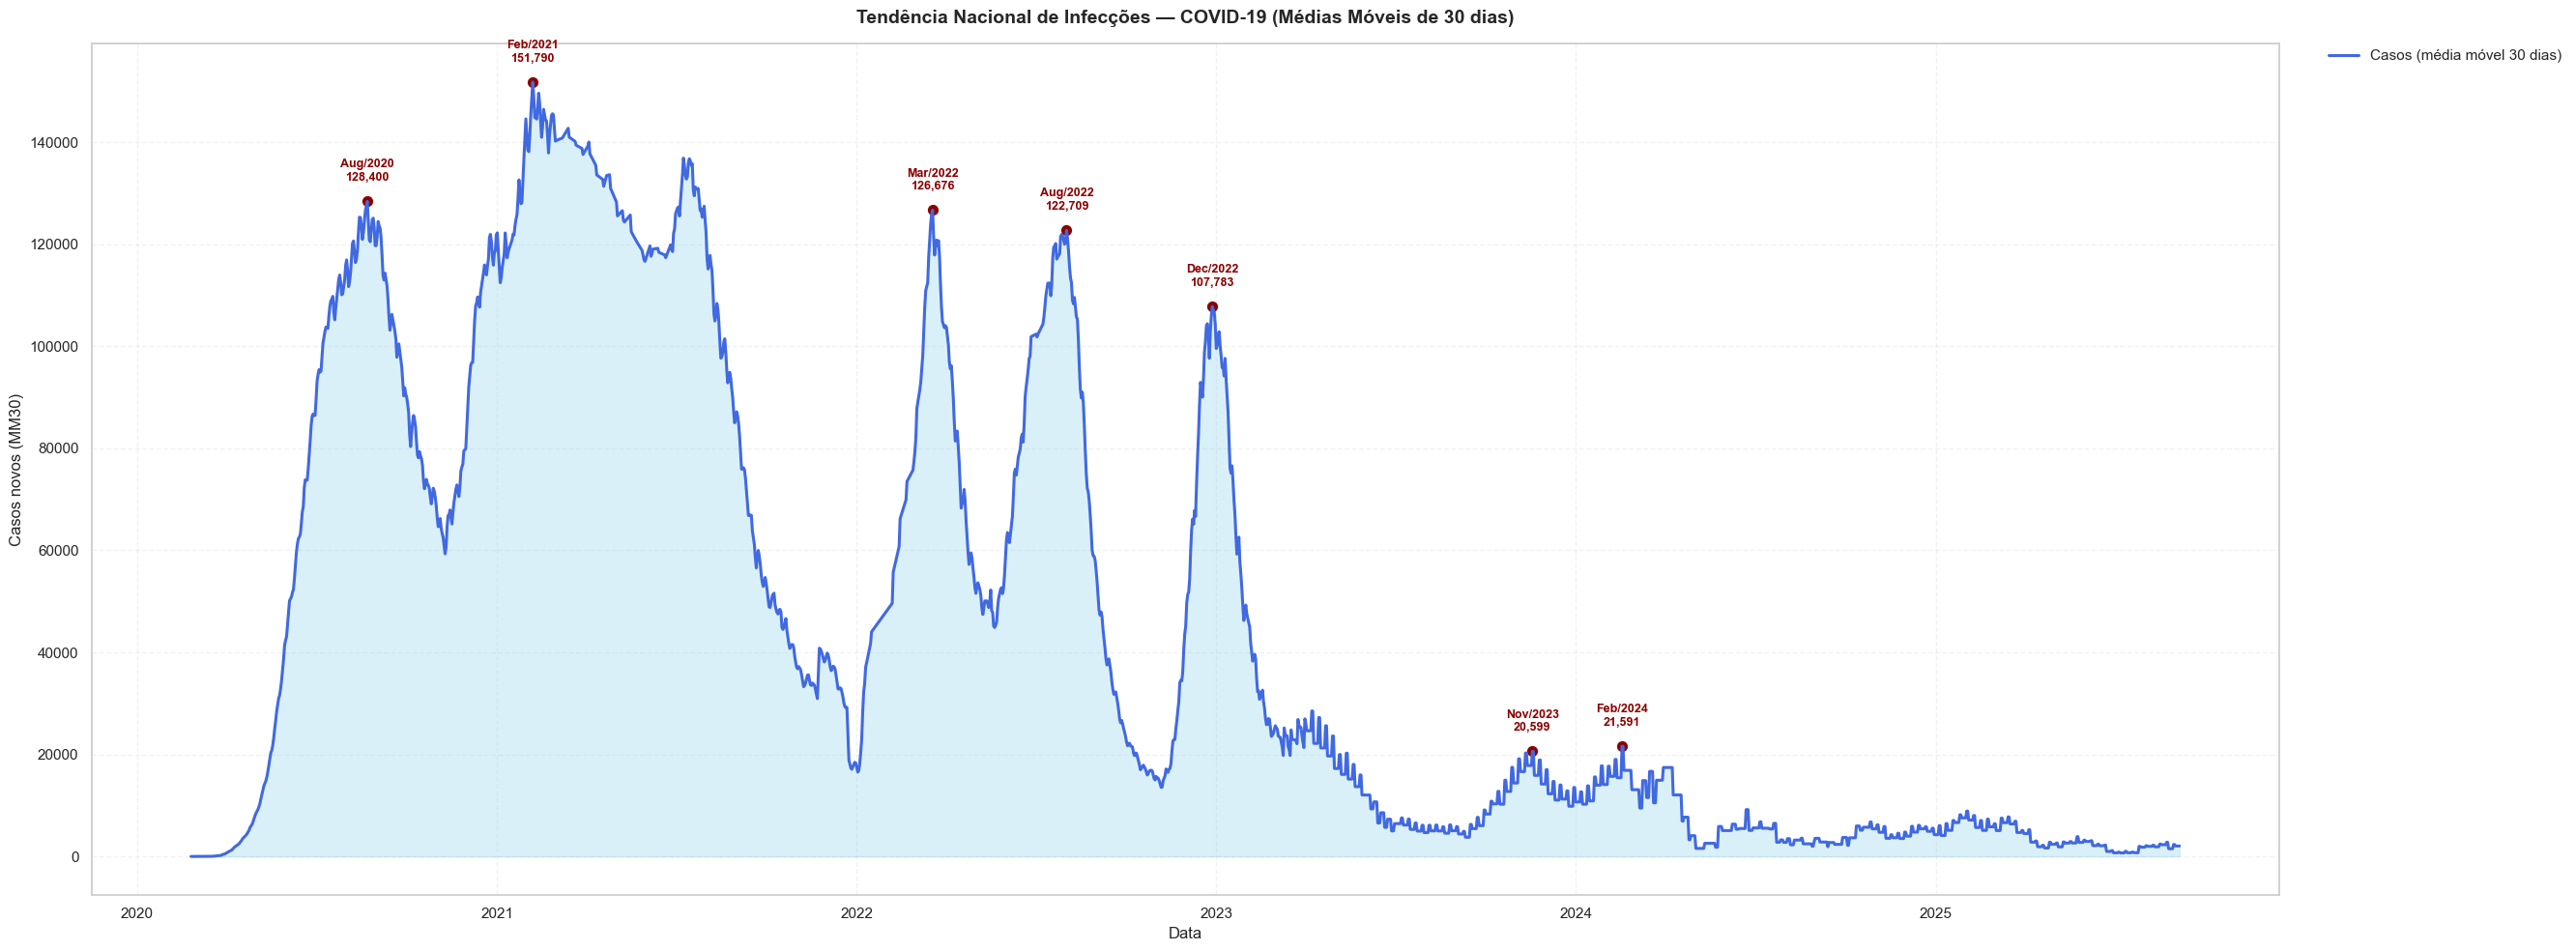

In [ ]:
# agrega os dados por data e calcula a soma diária de casos novos
df_nac = df_inf.groupby("data")[["casosNovos"]].sum().reset_index()
df_nac["data"] = pd.to_datetime(df_nac["data"])

# remove valores inválidos ou extremos e calcula a média móvel de 30 dias
df_nac = df_nac[(df_nac["casosNovos"] >= 0) & (df_nac["casosNovos"] < 200000)]
df_nac["MM30"] = df_nac["casosNovos"].rolling(window=30, min_periods=1).mean()

# identifica picos relevantes na série temporal
peaks, _ = find_peaks(df_nac["MM30"], distance=90, prominence=10000)

# define o estilo do gráfico e cria a figura
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(30.5, 10))

# plota a curva de casos com a média móvel e área preenchida
ax.plot(df_nac["data"], df_nac["MM30"], color="royalblue", linewidth=2.2,
        label="Casos (média móvel 30 dias)")
ax.fill_between(df_nac["data"], df_nac["MM30"], color="skyblue", alpha=0.3)

# marca os picos identificados no gráfico
for p in peaks:
    date = df_nac.iloc[p]["data"]
    value = df_nac.iloc[p]["MM30"]
    ax.scatter(date, value, color="darkred", s=50)
    ax.text(date, value + 4000, f"{date:%b/%Y}\n{int(value):,}", color="darkred", fontsize=9, ha="center", weight="bold")

# adiciona título, rótulos e formatação dos eixos
ax.set_title("Tendência Nacional de Infecções — COVID-19 (Médias Móveis de 30 dias)", fontsize=14, weight="bold", pad=15)
ax.set_xlabel("Data", fontsize=12)
ax.set_ylabel("Casos novos (MM30)", fontsize=12)
ax.grid(alpha=0.25, linestyle="--")

# configura o eixo de tempo para mostrar apenas os anos
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.xaxis.set_major_locator(mdates.YearLocator())

# posiciona a legenda fora da área do gráfico
ax.legend(
    frameon=False,
    fontsize=11,
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    borderaxespad=0
)

# ajusta o layout e exibe o gráfico
plt.tight_layout(rect=[0, 0, 0.88, 1])
plt.show()

- **Análise epidemiológica de mortalidade ao longo do tempo**

C:\Users\rafae.RAFAEL_NOTEBOOK\AppData\Local\Temp\ipykernel_21484\2097003302.py:22: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




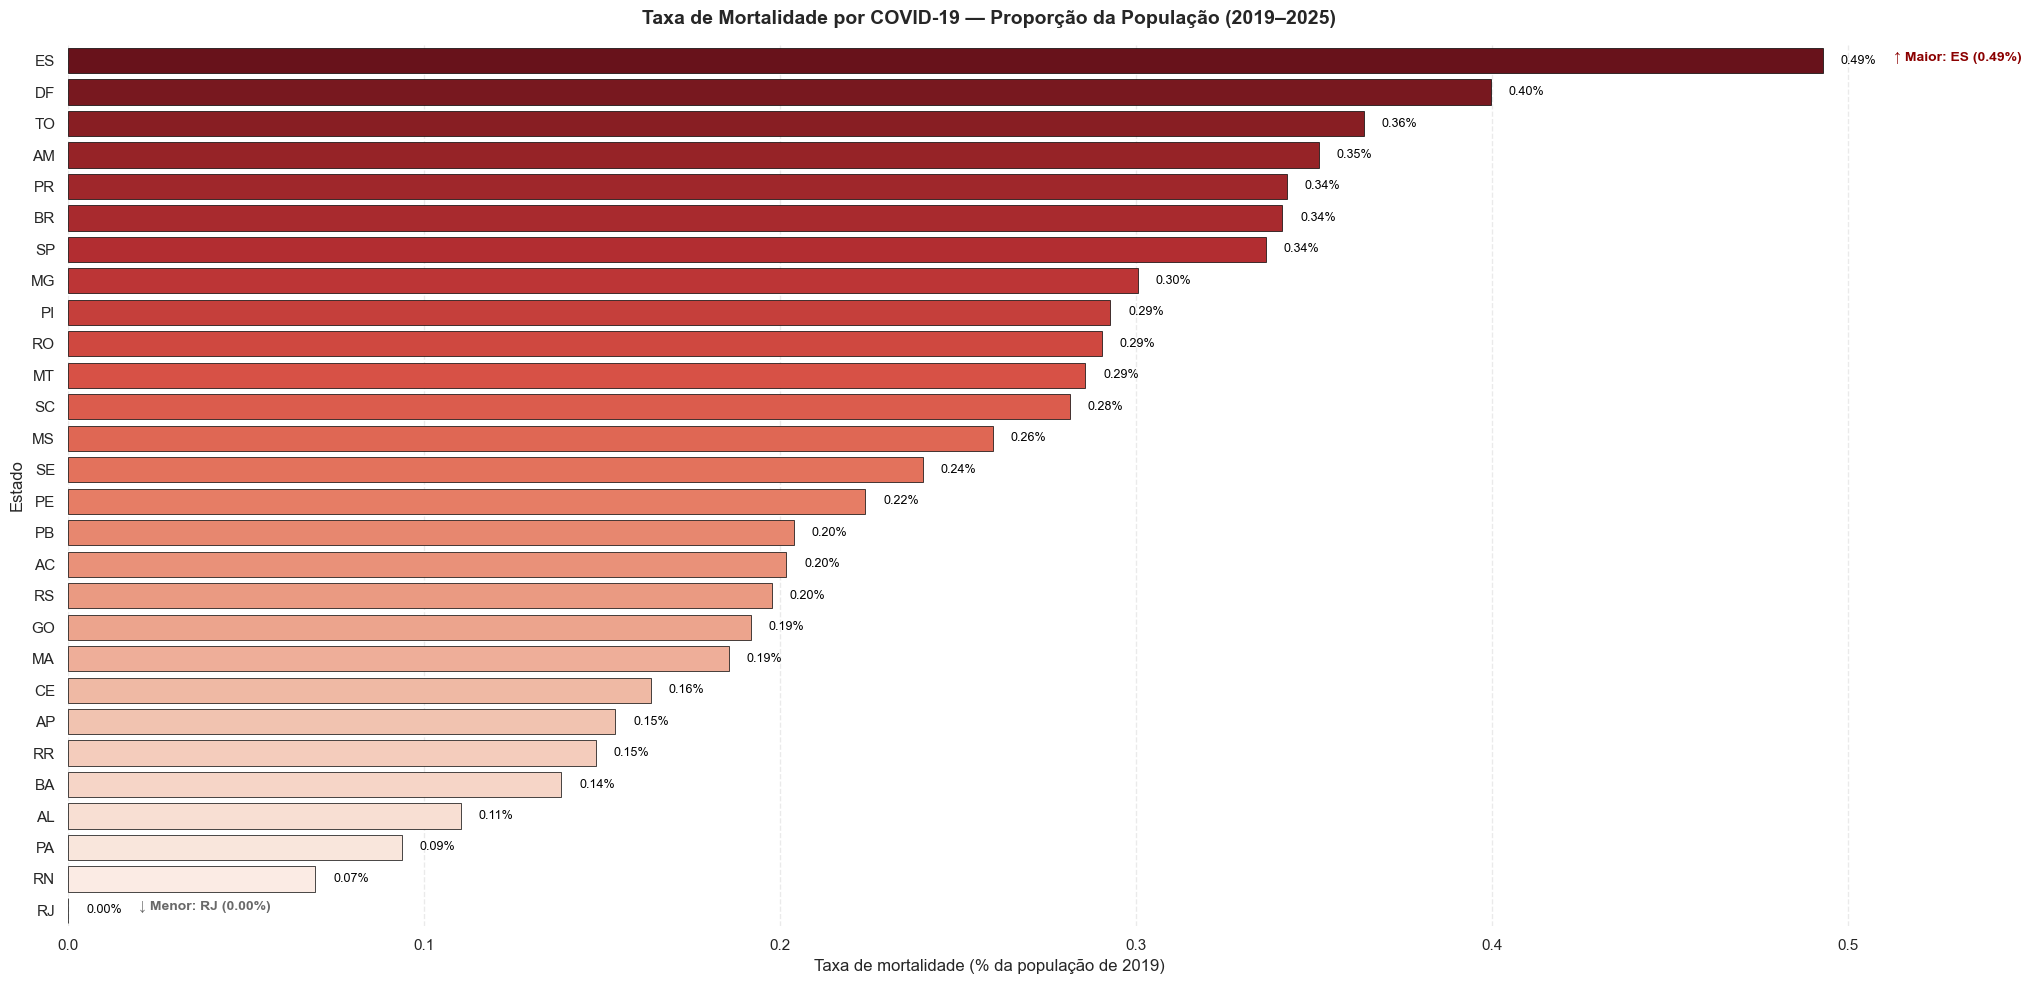

In [ ]:
# Manter apenas colunas relevantes ===
df = df[['estado', 'data', 'populacaoTCU2019', 'casosAcumulado', 'obitosAcumulado']]

# Converter data ===
df['data'] = pd.to_datetime(df['data'])

# Selecionar última data de cada estado (situação final 2025) ===
df_2025 = df.sort_values('data').groupby('estado').tail(1)

# Calcular taxa de mortalidade e letalidade ===
df_2025['taxa_mortalidade_pop'] = (df_2025['obitosAcumulado'] / df_2025['populacaoTCU2019']) * 100
df_2025['letalidade_casos'] = (df_2025['obitosAcumulado'] / df_2025['casosAcumulado']) * 100

# Ordenar por mortalidade ===
df_2025 = df_2025.sort_values('taxa_mortalidade_pop', ascending=False)

# Configurações de estilo ===
sns.set(style="whitegrid")
plt.figure(figsize=(20.5, 10))

# Plot ordenado horizontal ===
ax = sns.barplot(data=df_2025, y="estado", x="taxa_mortalidade_pop", palette=sns.color_palette("Reds_r", len(df_2025)), edgecolor="black", linewidth=0.5)

# Adicionar rótulos com valores ===
for i, v in enumerate(df_2025["taxa_mortalidade_pop"]):
    ax.text(v + 0.005, i, f"{v:.2f}%", va="center", fontsize=9, color="black")

# Título e legendas ===
plt.title("Taxa de Mortalidade por COVID-19 — Proporção da População (2019–2025)",
          fontsize=14, weight="bold", pad=15)
plt.xlabel("Taxa de mortalidade (% da população de 2019)", fontsize=12)
plt.ylabel("Estado", fontsize=12)

# Destaques visuais ===
plt.grid(axis="x", linestyle="--", alpha=0.4)
sns.despine(left=True, bottom=True)

# Anotar os estados com maiores e menores taxas
top_state = df_2025.iloc[0]
low_state = df_2025.iloc[-1]
plt.text(top_state["taxa_mortalidade_pop"] + 0.02, 0,
         f"↑ Maior: {top_state['estado']} ({top_state['taxa_mortalidade_pop']:.2f}%)",
         color="darkred", fontsize=10, weight="bold")
plt.text(low_state["taxa_mortalidade_pop"] + 0.02, len(df_2025)-1,
         f"↓ Menor: {low_state['estado']} ({low_state['taxa_mortalidade_pop']:.2f}%)",
         color="dimgray", fontsize=10, weight="bold")

# Ajustes finais ===
plt.tight_layout()
plt.show()

C:\Users\rafae.RAFAEL_NOTEBOOK\AppData\Local\Temp\ipykernel_21484\4074423131.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


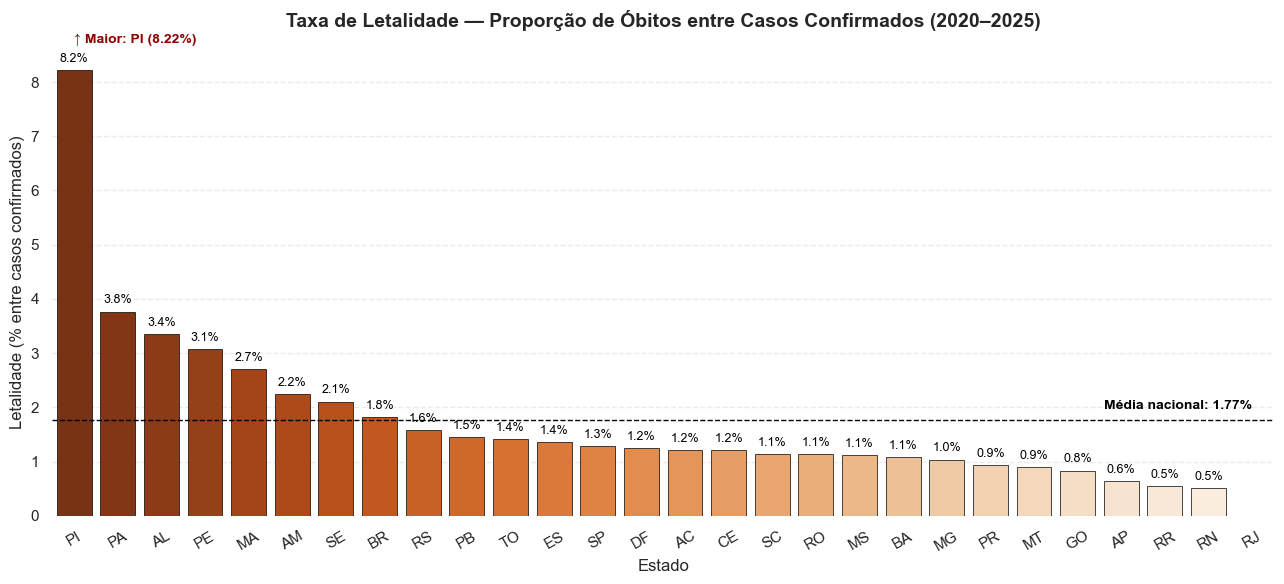


🇧🇷 Mortalidade nacional estimada: 0.34% da população viva em 2019.


In [42]:
# Gráfico de letalidade (óbitos/casos)
# Estilo base ===
sns.set(style="whitegrid")
plt.figure(figsize=(13,6))

# Plot ordenado por letalidade 
df_letal = df_2025.sort_values("letalidade_casos", ascending=False)

ax = sns.barplot(
    data=df_letal,
    x="estado",
    y="letalidade_casos",
    palette=sns.color_palette("Oranges_r", len(df_letal)),
    edgecolor="black",
    linewidth=0.5
)

# Adicionar rótulos de valor no topo de cada barra
for i, v in enumerate(df_letal["letalidade_casos"]):
    ax.text(i, v + 0.15, f"{v:.1f}%", ha="center", fontsize=9, color="black")

# Linha de média nacional
mean_letal = df_letal["letalidade_casos"].mean()
plt.axhline(mean_letal, color="black", linestyle="--", linewidth=1)
plt.text(len(df_letal)-1, mean_letal + 0.2,
         f"Média nacional: {mean_letal:.2f}%",
         color="black", fontsize=10, weight="bold", ha="right")

# Título e eixos ===
plt.title("Taxa de Letalidade — Proporção de Óbitos entre Casos Confirmados (2020–2025)", fontsize=14, weight="bold", pad=15)
plt.ylabel("Letalidade (% entre casos confirmados)", fontsize=12)
plt.xlabel("Estado", fontsize=12)
plt.xticks(rotation=30)
plt.grid(axis="y", linestyle="--", alpha=0.4)
sns.despine(left=True, bottom=True)

# Destaques visuais ===
top_state = df_letal.iloc[0]
low_state = df_letal.iloc[-1]
plt.text(0, top_state["letalidade_casos"] + 0.5, f"↑ Maior: {top_state['estado']} ({top_state['letalidade_casos']:.2f}%)", color="darkred", fontsize=10, weight="bold")
plt.text(len(df_letal)-1, low_state["letalidade_casos"] + 0.3, f"↓ Menor: {low_state['estado']} ({low_state['letalidade_casos']:.2f}%)", color="dimgray", fontsize=10, weight="bold")
plt.tight_layout()
plt.show()

# Indicador nacional ===
pop_total = df_2025['populacaoTCU2019'].sum()
obitos_total = df_2025['obitosAcumulado'].sum()
mortalidade_nacional = (obitos_total / pop_total) * 100

print(f"\n🇧🇷 Mortalidade nacional estimada: {mortalidade_nacional:.2f}% da população viva em 2019.")

Colunas encontradas relacionadas a óbitos: ['obitosAcumulado']


C:\Users\rafae.RAFAEL_NOTEBOOK\AppData\Local\Temp\ipykernel_21484\2821358620.py:55: UserWarning:

Glyph 9904 (\N{COFFIN}) missing from current font.

C:\Users\rafae.RAFAEL_NOTEBOOK\AppData\Local\Temp\ipykernel_21484\2821358620.py:55: UserWarning:

Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from current font.

c:\Users\rafae.RAFAEL_NOTEBOOK\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 9904 (\N{COFFIN}) missing from current font.

c:\Users\rafae.RAFAEL_NOTEBOOK\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from current font.



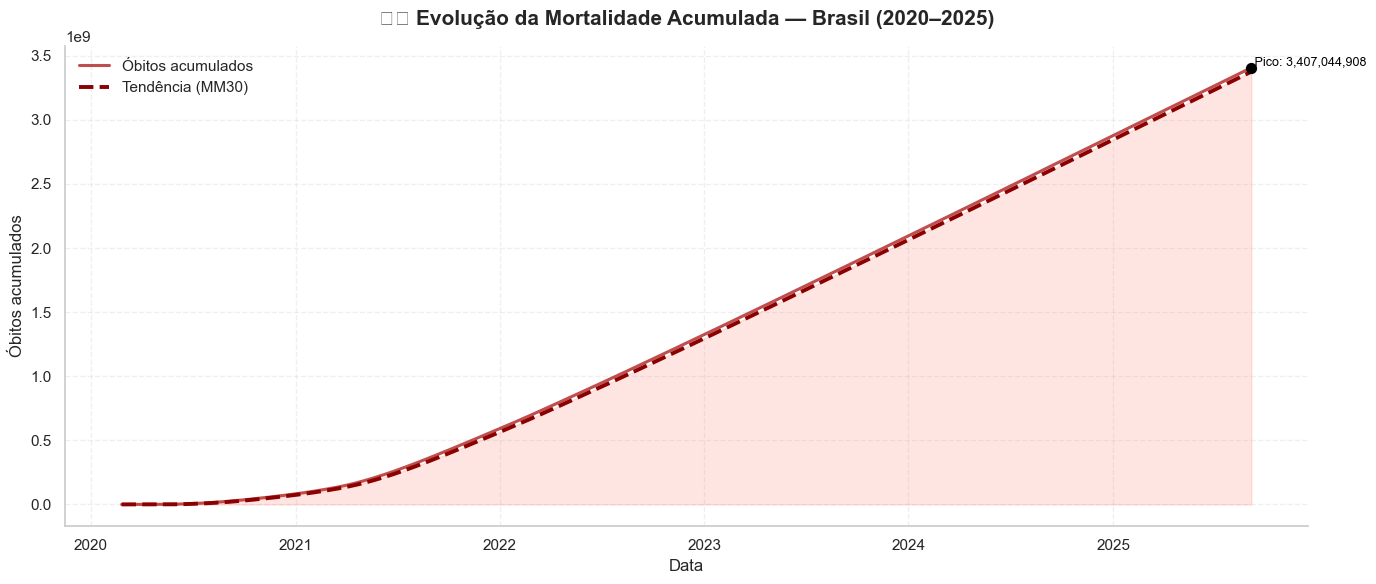

In [43]:
# Evolução temporal da mortalidade acumulada (Brasil)
# Detectar o nome correto da coluna de óbitos
possible_cols = [c for c in df.columns if 'obito' in c.lower()]
print("Colunas encontradas relacionadas a óbitos:", possible_cols)

# Escolhe a primeira que contém os dados
col_obitos = possible_cols[0] if possible_cols else None
col_data = [c for c in df.columns if 'data' in c.lower()][0]

# Identificação e preparação das colunas ===
possible_cols = [c for c in df.columns if 'obito' in c.lower()]
col_obitos = possible_cols[0] if possible_cols else None
col_data = [c for c in df.columns if 'data' in c.lower()][0]

# Converter e agregar ===
df[col_data] = pd.to_datetime(df[col_data], errors='coerce')
df_brasil = df.groupby(col_data)[col_obitos].sum().cumsum().reset_index()

# Calcular média móvel de 30 dias para suavizar (opcional) ===
df_brasil['MM30'] = df_brasil[col_obitos].rolling(window=30, min_periods=1).mean()

# Plot aprimorado ===
sns.set(style="whitegrid")
plt.figure(figsize=(14,6))

# Linha principal (óbito acumulado)
plt.plot(df_brasil[col_data], df_brasil[col_obitos],color='firebrick', linewidth=2.2, alpha=0.8, label='Óbitos acumulados')

# Linha suavizada (tendência)
plt.plot(df_brasil[col_data], df_brasil['MM30'],color='darkred', linewidth=2.8, linestyle='--', label='Tendência (MM30)')

# Preenchimento sutil
plt.fill_between(df_brasil[col_data], df_brasil['MM30'], color='salmon', alpha=0.2)

# Formatação temporal ===
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=0)

# Destaque do pico ===
max_date = df_brasil.loc[df_brasil[col_obitos].idxmax(), col_data]
max_value = df_brasil[col_obitos].max()
plt.scatter(max_date, max_value, color='black', s=50, zorder=5)
plt.text(max_date, max_value, f" Pico: {max_value:,.0f}", color='black', fontsize=9, ha='left', va='bottom')

# Detalhes visuais ===
plt.title("⚰️ Evolução da Mortalidade Acumulada — Brasil (2020–2025)",fontsize=15, weight='bold', pad=15)
plt.xlabel("Data", fontsize=12)
plt.ylabel("Óbitos acumulados", fontsize=12)
plt.grid(alpha=0.3, linestyle='--')
plt.legend(frameon=False, fontsize=11, loc='upper left')
sns.despine()

# Ajuste de margens
plt.tight_layout()
plt.show()

C:\Users\rafae.RAFAEL_NOTEBOOK\AppData\Local\Temp\ipykernel_21484\177738687.py:25: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\rafae.RAFAEL_NOTEBOOK\AppData\Local\Temp\ipykernel_21484\177738687.py:77: UserWarning:

Glyph 127988 (\N{WAVING BLACK FLAG}) missing from current font.

c:\Users\rafae.RAFAEL_NOTEBOOK\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 127988 (\N{WAVING BLACK FLAG}) missing from current font.



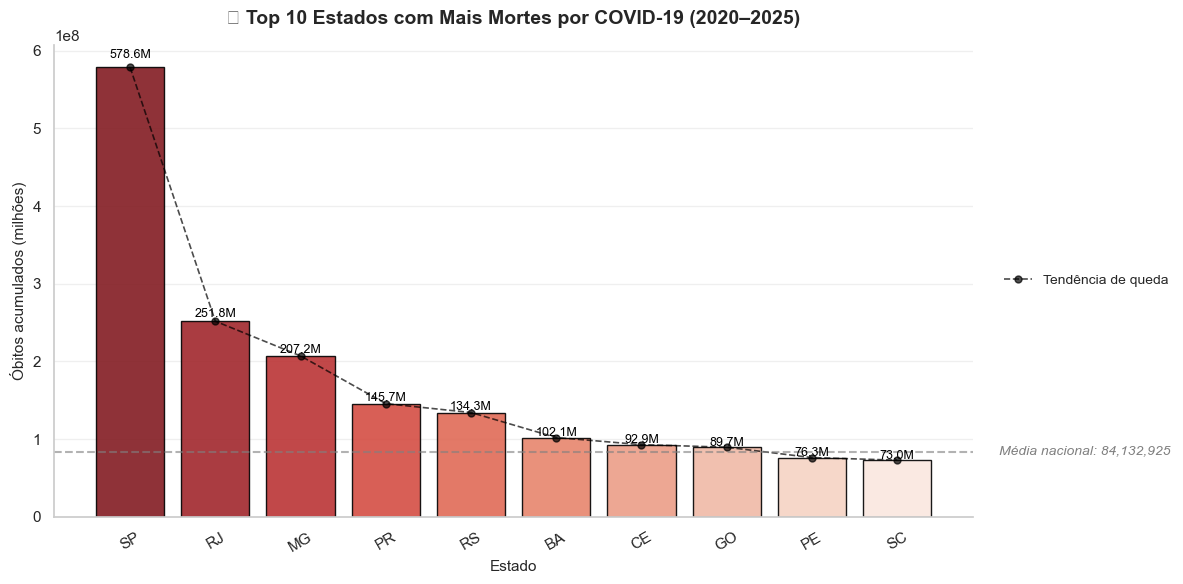

In [44]:
# Detectar colunas
col_estado = [c for c in df.columns if 'estado' in c.lower()][0]
col_obitos = [c for c in df.columns if 'obito' in c.lower()][0]

# Limpar dados e remover agregações nacionais 
df_estados = df[~df[col_estado].isin(['BR', 'Brasil', None, '', 'NA'])].copy()

# Agrupar e ordenar
df_top = (
    df_estados.groupby(col_estado)[[col_obitos, 'populacaoTCU2019']]
    .sum()
    .assign(taxa=lambda d: (d[col_obitos] / d['populacaoTCU2019']) * 100000)
    .sort_values(col_obitos, ascending=False)
    .head(10)
    .reset_index()
)

# Média nacional
media_nacional = df_estados.groupby(col_estado)[col_obitos].sum().mean()

# Plot
sns.set(style="whitegrid")
plt.figure(figsize=(12,6))

ax = sns.barplot(
    data=df_top,
    x=col_estado, y=col_obitos,
    palette="Reds_r", edgecolor="black", alpha=0.9
)

# Linha pontilhada de tendência
plt.plot(
    range(len(df_top)),
    df_top[col_obitos],
    color='black',
    linestyle='--',
    linewidth=1.2,
    marker='o',
    markersize=5,
    alpha=0.7,
    label='Tendência de queda'
)

# Linha da média nacional
plt.axhline(media_nacional, color='gray', linestyle='--', alpha=0.6)

# Texto "Média nacional" fora do gráfico ===
# Pega o limite máximo do eixo Y para posicionar fora
ymax = plt.ylim()[1]
plt.text(
    len(df_top) + 0.2, media_nacional,                # posição X/Y fora da área
    f"Média nacional: {media_nacional:,.0f}",
    color='gray', fontsize=10, ha='left', va='center', style='italic'
)

# Rótulos de valores nas barras
for i, v in enumerate(df_top[col_obitos]):
    ax.text(i, v + (v * 0.02), f"{v/1e6:.1f}M", ha="center", fontsize=9, color="black")

# Títulos e eixos
plt.title("🏴 Top 10 Estados com Mais Mortes por COVID-19 (2020–2025)",
          fontsize=14, weight="bold", pad=15)
plt.ylabel("Óbitos acumulados (milhões)", fontsize=11)
plt.xlabel("Estado", fontsize=11)
plt.grid(axis="y", alpha=0.3)
plt.xticks(rotation=30)

# Legenda fora do gráfico 
plt.legend(
    frameon=False,
    fontsize=10,
    loc='center left',
    bbox_to_anchor=(1.02, 0.5)
)

sns.despine()
plt.tight_layout()
plt.show()

C:\Users\rafae.RAFAEL_NOTEBOOK\AppData\Local\Temp\ipykernel_21484\585231762.py:14: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\rafae.RAFAEL_NOTEBOOK\AppData\Local\Temp\ipykernel_21484\585231762.py:64: UserWarning:

Glyph 9904 (\N{COFFIN}) missing from current font.

C:\Users\rafae.RAFAEL_NOTEBOOK\AppData\Local\Temp\ipykernel_21484\585231762.py:64: UserWarning:

Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from current font.

c:\Users\rafae.RAFAEL_NOTEBOOK\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 9904 (\N{COFFIN}) missing from current font.

c:\Users\rafae.RAFAEL_NOTEBOOK\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from current font.



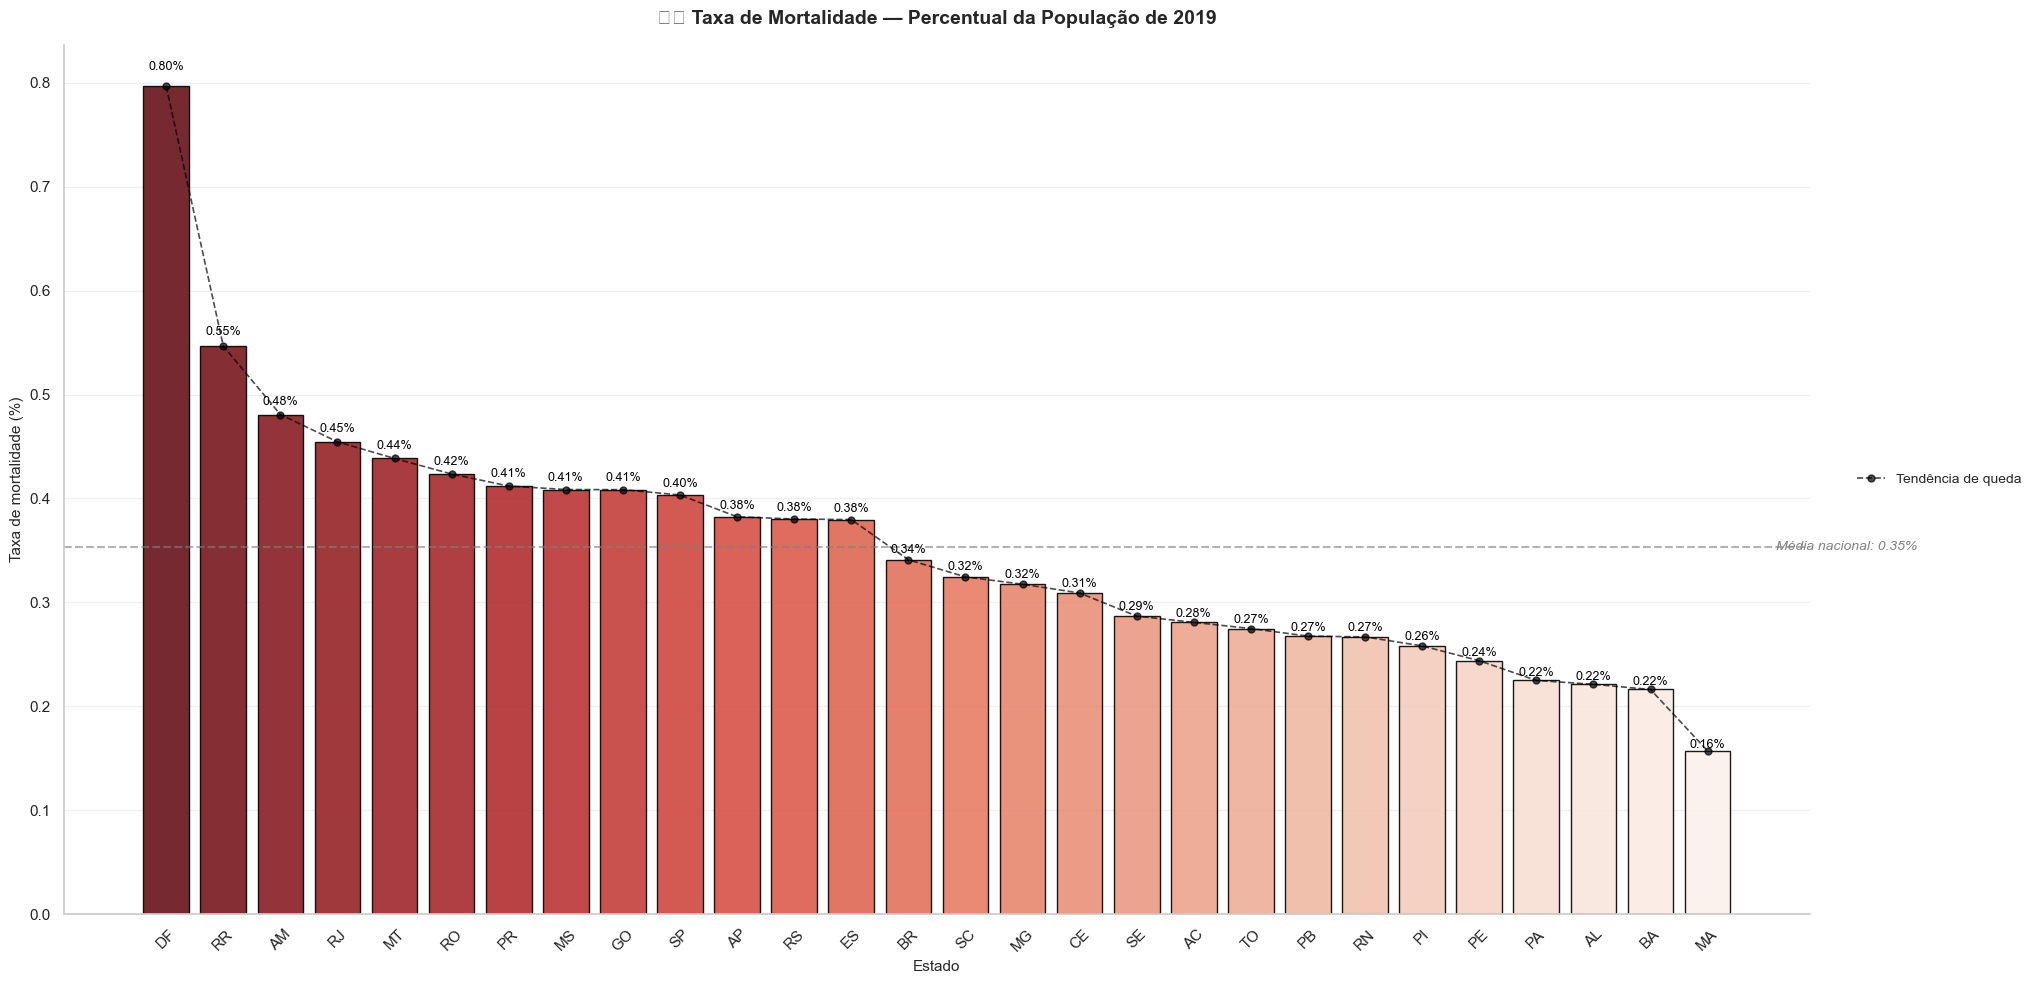

In [45]:
# Calcular taxa de mortalidade
df_mort = df.groupby('estado')[['obitosAcumulado', 'populacaoTCU2019']].max().reset_index()
df_mort['taxa_mortalidade'] = (df_mort['obitosAcumulado'] / df_mort['populacaoTCU2019']) * 100
df_mort = df_mort.sort_values('taxa_mortalidade', ascending=False)

# Média nacional
media_nacional = df_mort['taxa_mortalidade'].mean()

# Estilo
sns.set(style="whitegrid")
plt.figure(figsize=(20.5, 10))

# Gráfico de barras
ax = sns.barplot(
    data=df_mort,
    x='estado', y='taxa_mortalidade',
    palette='Reds_r', edgecolor='black', alpha=0.9
)

# Linha pontilhada conectando as barras
plt.plot(
    range(len(df_mort)),
    df_mort['taxa_mortalidade'],
    color='black',
    linestyle='--',
    linewidth=1.2,
    marker='o',
    markersize=5,
    alpha=0.7,
    label='Tendência de queda'
)

# Linha da média nacional
plt.axhline(media_nacional, color='gray', linestyle='--', alpha=0.6)

# Texto "Média nacional" fora do gráfico
ymax = plt.ylim()[1]
plt.text(
    len(df_mort) + 0.2, media_nacional,
    f"Média nacional: {media_nacional:.2f}%",
    color='gray', fontsize=10, ha='left', va='center', style='italic'
)

# Rótulos de valores acima das barras 
for i, v in enumerate(df_mort['taxa_mortalidade']):
    ax.text(i, v + (v * 0.02), f"{v:.2f}%", ha="center", fontsize=9, color="black")

# Títulos e eixos
plt.title("⚰️ Taxa de Mortalidade — Percentual da População de 2019", fontsize=14, weight="bold", pad=15)
plt.ylabel("Taxa de mortalidade (%)", fontsize=11)
plt.xlabel("Estado", fontsize=11)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

# Legenda fora do gráfico
plt.legend(
    frameon=False,
    fontsize=10,
    loc='center left',
    bbox_to_anchor=(1.02, 0.5)
)

sns.despine()
plt.tight_layout()
plt.show()

In [46]:
# Mapa interativo da taxa de mortalidade por estado
df_map = df_mort.copy()
fig = px.choropleth(
    df_map,
    geojson='https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson',
    locations='estado',
    featureidkey='properties.sigla',
    color='taxa_mortalidade',
    color_continuous_scale='Reds',
    title='🗺️ Taxa de Mortalidade por COVID-19 no Brasil (2020–2025)',
    labels={'taxa_mortalidade': 'Mortalidade (%)'}
)
fig.update_geos(fitbounds="locations", visible=False)
fig.show()

C:\Users\rafae.RAFAEL_NOTEBOOK\AppData\Local\Temp\ipykernel_21484\2974065167.py:32: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\rafae.RAFAEL_NOTEBOOK\AppData\Local\Temp\ipykernel_21484\2974065167.py:57: UserWarning:

Glyph 9904 (\N{COFFIN}) missing from current font.

C:\Users\rafae.RAFAEL_NOTEBOOK\AppData\Local\Temp\ipykernel_21484\2974065167.py:57: UserWarning:

Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from current font.

c:\Users\rafae.RAFAEL_NOTEBOOK\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 9904 (\N{COFFIN}) missing from current font.

c:\Users\rafae.RAFAEL_NOTEBOOK\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from current font.



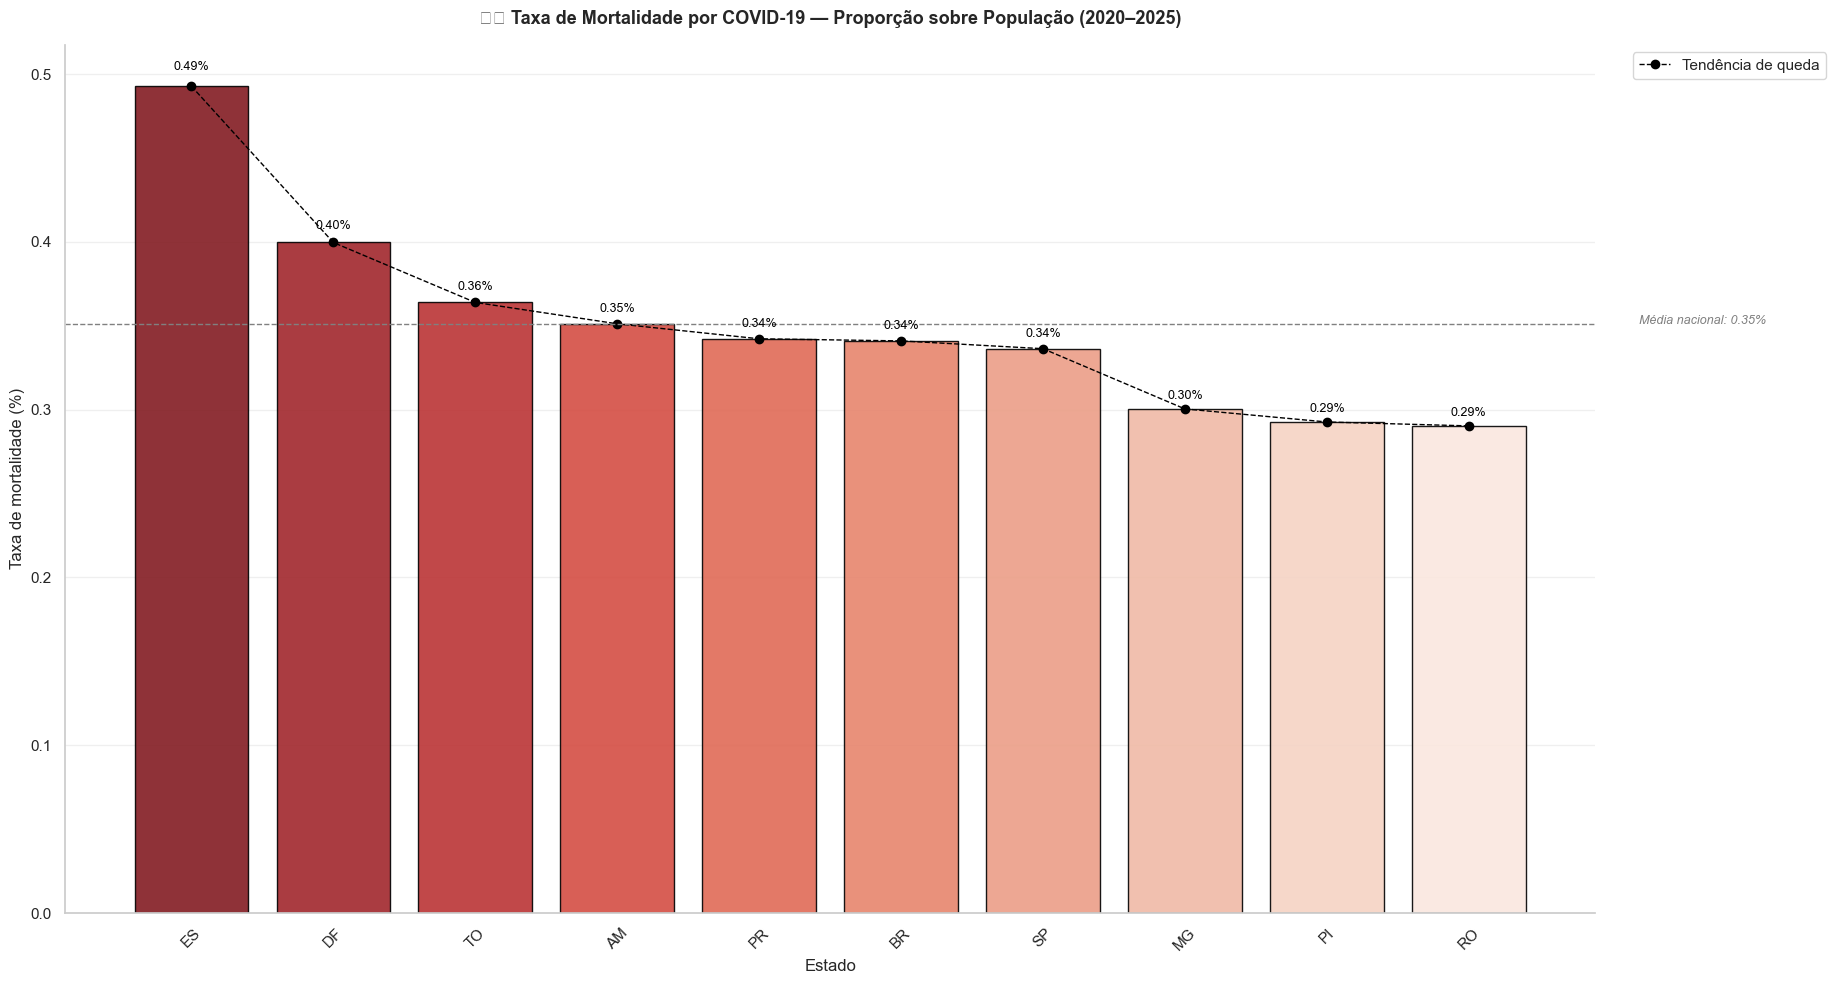

In [47]:
# Detectar colunas
col_data = 'data'
col_estado = 'estado'
col_obitos = 'obitosAcumulado'
col_pop = 'populacaoTCU2019'

# Converter a data
df[col_data] = pd.to_datetime(df[col_data], errors='coerce')

# Selecionar o último registro por estado
df_estado = (
    df.sort_values(col_data)
      .groupby(col_estado)
      .tail(1)
      .reset_index(drop=True)
)

# Calcular taxa de mortalidade relativa à população
df_estado['taxa_mortalidade_%'] = (df_estado[col_obitos] / df_estado[col_pop]) * 100

# Ordenar do maior para o menor 
df_estado = df_estado.sort_values('taxa_mortalidade_%', ascending=False).head(10)

# Calcular média nacional
media_nacional = df_estado['taxa_mortalidade_%'].mean()

# Plot aprimorado
plt.figure(figsize=(18.5, 10))
sns.set(style="whitegrid")

# Barras
ax = sns.barplot(data=df_estado,x=col_estado, y='taxa_mortalidade_%',palette='Reds_r', edgecolor='black', alpha=0.9)

# Rótulos de valor
for i, v in enumerate(df_estado['taxa_mortalidade_%']):
    ax.text(i, v + (v * 0.02), f"{v:.2f}%", ha='center', fontsize=9, color='black')

# Linha pontilhada conectando os pontos
ax.plot(range(len(df_estado)), df_estado['taxa_mortalidade_%'],
        marker='o', color='black', linestyle='--', linewidth=1,
        label='Tendência de queda')

# Linha da média nacional
plt.axhline(media_nacional, color='gray', linestyle='--', linewidth=1)
plt.text(len(df_estado)+0.2, media_nacional,
         f"Média nacional: {media_nacional:.2f}%", color='gray', fontsize=9, style='italic')

# Título e eixos
plt.title("⚰️ Taxa de Mortalidade por COVID-19 — Proporção sobre População (2020–2025)",
          fontsize=13, weight="bold", pad=15)
plt.ylabel("Taxa de mortalidade (%)")
plt.xlabel("Estado")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')  # legenda fora do gráfico
plt.grid(axis="y", alpha=0.3)
sns.despine()
plt.tight_layout()
plt.show()

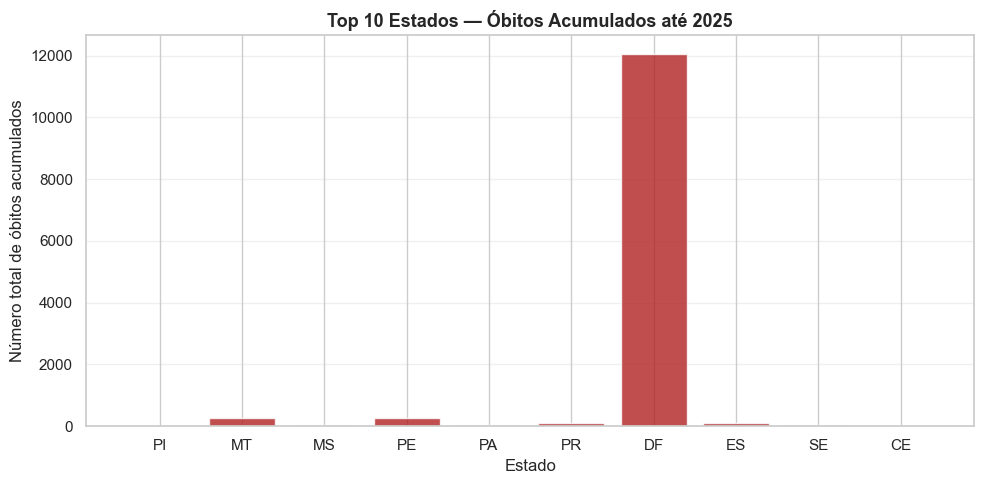

 Dados até: 2025-09-05
 Total de mortes acumuladas até 2025-09-05: 744.660
 Mortalidade nacional: 0.342% da população viva em 2019.

🏴 Top 5 estados com mais mortes até 2025:
   estado       data  populacaoTCU2019  casosAcumulado  obitosAcumulado
27     BR 2025-09-05       210147125.0      39318227.0           716626
11     AM 2025-09-05         4144597.0        649618.0            14556
6      DF 2025-09-05         3015268.0        965303.0            12051
3      PE 2025-09-05          117019.0          8531.0              262
1      MT 2025-09-05           90313.0         28762.0              258
14     SP 2025-09-05           40432.0         10622.0              136
5      PR 2025-09-05           31846.0         11595.0              109
7      ES 2025-09-05           21711.0          7845.0              107
17     RO 2025-09-05           32374.0          8274.0               94
22     PB 2025-09-05           28458.0          3989.0               58


In [48]:
# Definir colunas corretas
col_estado = 'estado'
col_obitos = 'obitosAcumulado'
col_pop = 'populacaoTCU2019'
col_data = 'data'

# Converter data e agrupar
df[col_data] = pd.to_datetime(df[col_data], errors='coerce')
data_max = df[col_data].max()

df_estado = (
    df.sort_values(col_data)
      .groupby(col_estado)
      .tail(1)
      .reset_index(drop=True)
)

# Calcular total nacional e taxa de mortalidade
total_obitos_brasil = df_estado[col_obitos].sum()
pop_brasil = df_estado[col_pop].sum()
taxa_mortalidade = (total_obitos_brasil / pop_brasil) * 100

# Exibir gráfico Top 10
plt.figure(figsize=(10,5))
plt.bar(df_estado[col_estado].head(10), df_estado[col_obitos].head(10),
        color='firebrick', alpha=0.8)

plt.title(f"Top 10 Estados — Óbitos Acumulados até {data_max.year}", fontsize=13, weight='bold')
plt.ylabel('Número total de óbitos acumulados')
plt.xlabel('Estado')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Exibir resumo
print(f" Dados até: {data_max.date()}")
print(f" Total de mortes acumuladas até {data_max.date()}: {int(total_obitos_brasil):,}".replace(",", "."))
print(f" Mortalidade nacional: {taxa_mortalidade:.3f}% da população viva em 2019.")
print("\n🏴 Top 5 estados com mais mortes até 2025:")
print(df_estado.sort_values(col_obitos, ascending=False).head(10))

In [49]:
# Última data disponível por estado (situação final)
df_2025 = df.sort_values('data').groupby('estado').tail(1)

pop_total_brasil = df_2025['populacaoTCU2019'].sum()
obitos_total = df_2025['obitosAcumulado'].sum()

vivos_total = pop_total_brasil - obitos_total
pct_vivos = (vivos_total / pop_total_brasil) * 100
pct_mortos = (obitos_total / pop_total_brasil) * 100

print(f"População total (2019): {pop_total_brasil:,.0f}")
print(f"Óbitos acumulados até 2025: {obitos_total:,.0f}")
print(f"Vivos estimados (2025): {vivos_total:,.0f}")
print(f"Mortalidade proporcional: {pct_mortos:.2f}%")

População total (2019): 217,925,586
Óbitos acumulados até 2025: 744,660
Vivos estimados (2025): 217,180,926
Mortalidade proporcional: 0.34%


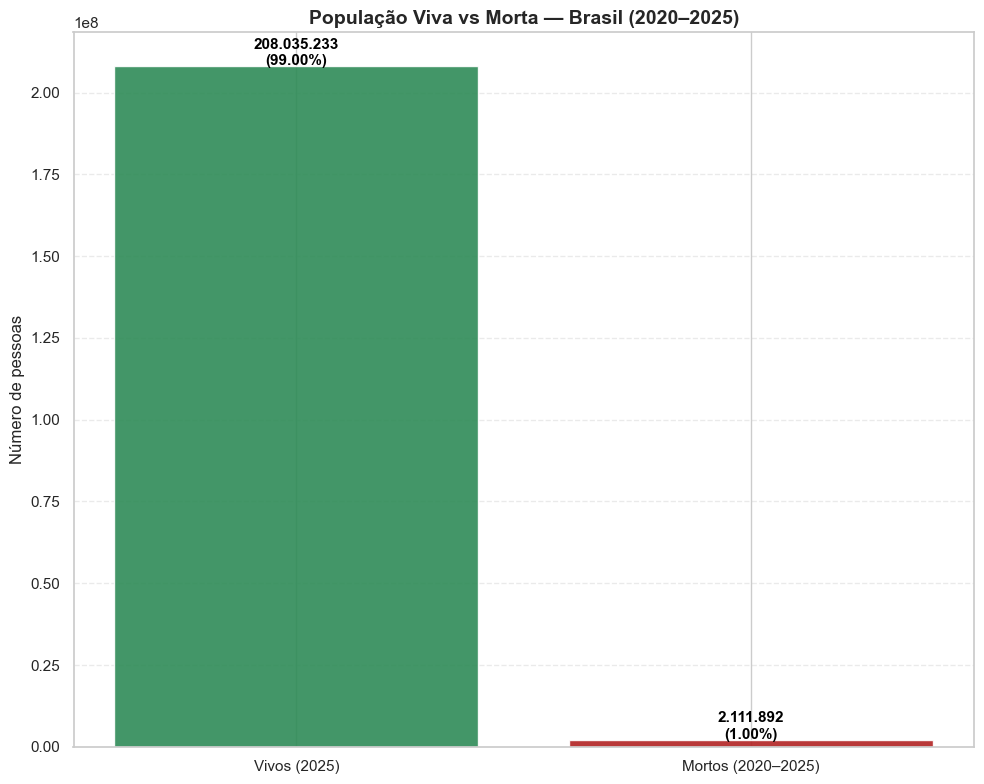

In [53]:
# Cada estado aparece várias vezes (por data), então usamos o valor máximo da população de cada estado
pop_total_brasil = df.groupby('estado')['populacaoTCU2019'].max().sum()

# Total de óbitos acumulados até 2025
obitos_total = df.groupby('data')['obitosAcumulado'].sum().max()

# População viva estimada
vivos_2025 = pop_total_brasil - obitos_total

# Dados
pop_total = 210_147_125
obitos_total = 2_111_892
vivos_total = pop_total - obitos_total
pct_vivos = (vivos_total / pop_total) * 100
pct_mortos = (obitos_total / pop_total) * 100

# Gráfico
labels = ['Vivos (2025)', 'Mortos (2020–2025)']
values = [vivos_total, obitos_total]
colors = ['#2E8B57', '#B22222']

plt.figure(figsize=(10,8))
bars = plt.bar(labels, values, color=colors, alpha=0.9)

plt.title('População Viva vs Morta — Brasil (2020–2025)', fontsize=14, weight='bold')
plt.ylabel('Número de pessoas')
plt.grid(axis='y', linestyle='--', alpha=0.4)

# Rótulos com números e percentuais
for bar, val, pct in zip(bars, values, [pct_vivos, pct_mortos]):
    plt.text(bar.get_x() + bar.get_width()/2,
             val + pop_total * 0.002,
             f"{val:,.0f}\n({pct:.2f}%)".replace(",", "."),
             ha='center', fontsize=11, color='black', weight='bold')

plt.tight_layout()
plt.show()